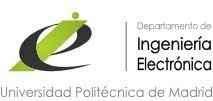

<div align="center"> 

# Practice: Smart Health 
## Physical Activity Recognition based on 3D accelerometer

---
---

Cristina Luna Jiménez, Fernando Fernández-Martínez,
Jose Manuel Pardo Muñoz, Ricardo Kleinlein
</div>



### Introduction



In many contexts, having information about **the movements of a person could help to diagnose certain deseases**. One clear example can be Parkinson, a progressive disorder that affects the nervous system and movement. In some cases, it starts with soft tremblings that are not perceptible by the human-eye but easy to detect by an inertial sensor. 
This example illustrates how attaching inertial sensors to different parts of the body could help to make an early diagnosis of certain illness and implement sollutions: "Smart" Spoon for Parkinson's Sufferers (https://www.youtube.com/watch?v=WiVQcgmIi08&ab_channel=BrianMKAllen). 

The image below represents the overall diagram of a remote monitoring system for patients with diseases of musculoskeletal system, based on data collected from different types of motion sensors (accelerometers, magnetometers, gyroscopes...). Data collected by these sensors give information about the movements (and related activities) that the person performs. Once the raw signals are obtained, they can be pre-processed to remove noise, filter spourious signals and compute compact features for training a machine-learning model. 

In this practice we will develope a simple **hand gesture recognizer based on 3D pattern assembled trajectories recorded by an accelerometer sensor**.  


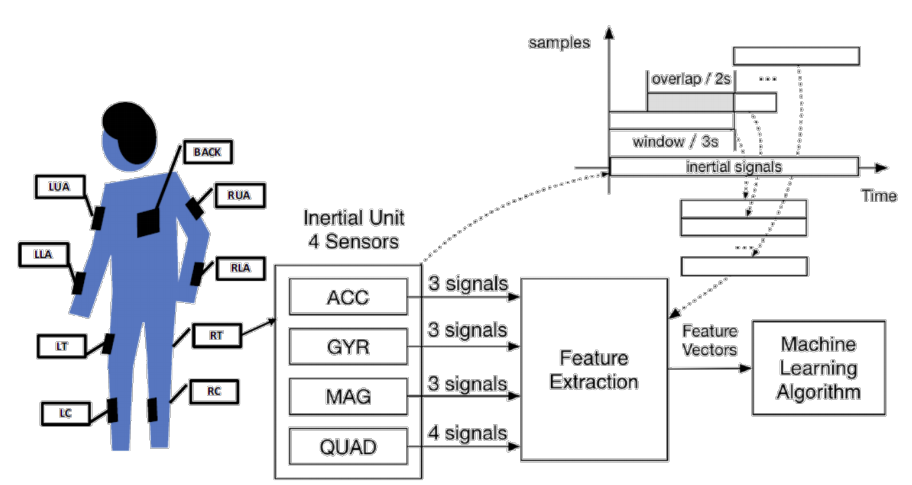


**Data Analysis**

As introduced before, in this session we will work with 3D data (X, Y, Z axis) obtained from accelerometers. Data was collected from 22 participants that are doing one of the following table-tennis movements: 
* DRIVE (1)  [ https://youtu.be/h-Qqe0Ty9KI ]
* BACKHAND (2) [ https://youtu.be/cgdeQllLahE ]
* SERVE (3) [ https://youtu.be/s9ELscafqVs ]
* LOB (4). [ https://www.youtube.com/watch?v=cSjgUoc198Q&ab_channel=PingSkills ]

These activities conform the classes between we should discern distributed uniformly in the dataset. 

The corpus contains 10.560 instances with 200 attributes per axis (one sample lasts 4 seconds, being the sampling frequency of the acceleromenter 50 Hz). Overall, each instance has 600 attributes.  

These 10.560 instances are distributed in 63.63% for the training set (6.720) and a 36.36% for test set (3.840). 


As it is shown in the slices of the subject, Weka lets make a first simple visual analysis of the attributes that could give better results to distinguish between classes. Try to load the training arff and visualize the distributions of the classes and the relation between pairs of attributes. 


**Summary**

This practice is dedicated to the familiarization with the tools introduced during the course, more specifically, to Weka and Tensorflow. 

The main concepts that we will work are: 

1. Firstly, we will study how the algorithms perform introducing raw data. As an example, we will use a Decission Tree available in Weka (J48) although other algorithms can be tested too. 
2. Secondly, we will extract some features from the raw accelerometer signal, more concretely, MFCCs (Mel-frequency cepstral coefficients) and functionals (mean and standard deviation) from each axis, and we will train another J48 Tree. For more information about these features, visit: (https://medium.com/@jonathan_hui/speech-recognition-feature-extraction-mfcc-plp-5455f5a69dd9) 
3. Thirdly, we will compare the results of the 2 previous approaches with those obtained with a a LSTM (Long Short-Term Memory), a type of recurrent neural network. 


# Environment Set-up

In this section, we will download all the neccessary packages for running the experiments. 

Among the packages and libraries installed, the most important are:

*   **oct2py**: This Python library lets run m-files from Python. Function in this practice: Extract MFCC features and their functionals.
*   **python-weka-wrapper**: This python library makes easy to run Weka algorithms from Python. It offers access to Weka API using thin wrappers around JNI calls employing the javabridge package. Function in this practice: Training-Evaluation-Testing algorithms.
* **pandas**: Python library that lets deal with csv and convert them to a DataFrame, type of data organization in a kind of table format. 
* **tensorflow**: Open source software library for numerical computation using data-flow graphs and for implementing and training artificial neural networks. 
* **numpy**: This Python library is oriented to make numeric operactions, algebra and mathematic analysis.
* **matplotlib**: This Python library contains graphic plot functions, similr to the resources available in Matlab for showing graphs.

As first action, run all the cells that you find below until the next section (READ IMPORTANT MESSAGE BELOW), in this way we will set-up the environment.


**IMPORTANT:** For the third cell, we should pay attention to the message that appears during the authentication process, since it asks for introducing a code into an empty field. This code is provided after clicking on the link that is located above the empty rectangle. Once the link is opened in a new window, we should copy the code into the empty rectangle and press Enter to continue with the process. 


In [1]:
#Install oct2py and its libraries
!apt-get build-dep octave
!apt install octave
!pip install oct2py
!apt-get install unzip
!apt-get install -y octave-tsa
!apt-get install -y octave-linear-algebra
!apt-get install octave-signal

Reading package lists... Done
E: Unable to find a source package for octave
Reading package lists... Done
Building dependency tree       
Reading state information... Done
octave is already the newest version (4.2.2-1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
octave-tsa is already the newest version (4.4.5-3).
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
octave-linear-algebra is already the newest version (2.2.2-4).
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.
Reading package lists... Done
Building dependency tree       

In [2]:
#TEST oct2py is installed
from oct2py import octave
x = octave.zeros(3,3)
print(x, x.dtype)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]] float64


In [3]:
# 3rd cell
# IMPORT DATA FROM OTHERS DRIVE:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
#Install octave FFM libraries
# NOTE: If you receive the following error: ModuleNotFoundError: No module named 'google.appengine' ...
# WAIT for some minutes until GoogleAuth detect your credentials, if it still doesn't work, run previous cell again
link_octave_zip = "https://drive.google.com/file/d/1J2TH9Ssc8VjjftkS3E9vF0U3TRZUvvGl/view?usp=sharing"
id_octave = link_octave_zip.split('/d/')[1].split("/")[0]
downloaded_octave = drive.CreateFile({'id':id_octave}) 
downloaded_octave.GetContentFile('octave.zip')  
!unzip octave.zip -d /usr/local/lib

Archive:  octave.zip
replace /usr/local/lib/octave/allcomb.m? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /usr/local/lib/octave/allcomb.m  
  inflating: /usr/local/lib/octave/applyW.m  
  inflating: /usr/local/lib/octave/audspec.m  
  inflating: /usr/local/lib/octave/bark2hz.m  
  inflating: /usr/local/lib/octave/box_lik.m  
  inflating: /usr/local/lib/octave/boxc_trans.m  
  inflating: /usr/local/lib/octave/boxcox.m  
  inflating: /usr/local/lib/octave/cabecera.arff  
  inflating: /usr/local/lib/octave/calcula_features.m  
  inflating: /usr/local/lib/octave/calcula_features_mfcc_plp.m  
  inflating: /usr/local/lib/octave/calcula_features_mfcc_plp_online.m  
  inflating: /usr/local/lib/octave/calcula_features_mfcc_plp_online_new.m  
  inflating: /usr/local/lib/octave/calcula_features_mfcc_plp_online_ori.m  
  inflating: /usr/local/lib/octave/cep2spec.m  
  inflating: /usr/local/lib/octave/CMN_mean_vector.txt  
  inflating: /usr/local/lib/octave/dbnsetup.m  
  inflating: /usr/l

In [5]:
# For more info, see: https://colab.research.google.com/github/kzafeiroudi/QuestRecommend/blob/master/TrainingOnQuora.ipynb#scrollTo=mrcWHtCRqFl-
# Install java and set environment variable
import os       #importing os to set environment variable
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

openjdk version "11.0.8" 2020-07-14
OpenJDK Runtime Environment (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1)
OpenJDK 64-Bit Server VM (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1, mixed mode, sharing)


In [6]:
# Install other libraries and python-weka-wrapper3
!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
!pip install cython
!pip install python-weka-wrapper3

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libproj-dev is already the newest version (4.9.3-2).
proj-bin is already the newest version (4.9.3-2).
proj-data is already the newest version (4.9.3-2).
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.


# Functions

Under this section, we can see the funcions that we will use in the 3 scenarios described briefly at the beginning. 

We have 4 groups of functions:

## Common

In this first group, we have a collection of common functions that convert data types and let plot images on different sections.

Run it now to have the functions ready for applying them later. 

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn import decomposition
from sklearn import datasets



def Convert2nominal_activities(class_number):
  if(class_number == 1):
    return "RUNNING"
  elif(class_number == 2):
    return "STEP"
  elif(class_number == 3):
    return "SQUAT"
  elif(class_number == 4):
    return "CIRCLES"
  else:
    return "UNK"

def Convert2nominal_pingPong(class_number):
  """
    Transform numerical class to nominal classes
    :param class_number: Number of class in numeric format
    :return: Class as string (nominal type)
  """
  if(class_number == 1):
    return "DRIVE"
  elif(class_number == 2):
    return "BACKHAND"
  elif(class_number == 3):
    return "SERVE"
  elif(class_number == 4):
    return "LOB"
  else:
    return "UNK"



def GetAccelerationAxis(df_csv):
  """
    Get arrays of X,Y and Z axis, as well as the class attribute and an array with all the parameters of the 3 axis.
    :param df_csv: Dataframe with the initial 600 parameters (or raw samples)
  """
  AccX_array = df_csv.loc[:, 'param1':'param200']
  AccY_array = df_csv.loc[:, 'param201':'param400']
  AccZ_array = df_csv.loc[:, 'param401':'param600']
  AccAll_array = df_csv.loc[:, 'param1':'param600']
  y = df_csv["class"]
  return AccX_array, AccY_array, AccZ_array, AccAll_array, y



#PLOT FUNCTIONS:

# SIMPLE PLOT PER SAMPLES 
def plot_sample(sample2plot, df_csv, fig=None):
  """
    Plot X,Y,Z raw samples of the acceleration. 
    X axis is painted in red, Y xis in green and Z axis in blue. 
    :param sample2plot: Number of the sample to plot
    :param df_csv: Dataframe with the initial 600 parameters (or raw samples)
  """
  #PLOT SIMPLE INSTANCE VALUES
  AccX_array_train = df_csv.loc[sample2plot, 'param1':'param200']
  AccY_array_train = df_csv.loc[sample2plot, 'param201':'param400']
  AccZ_array_train = df_csv.loc[sample2plot, 'param401':'param600']
  t = np.linspace(0, 4, 200)

  
  fig = plt.figure(figsize=(10, 10))
  plt.plot(t, AccX_array_train, color='r', label = "X") # plotting t, a separately 
  plt.plot(t, AccY_array_train, color='g', label = "Y") # plotting t, b separately 
  plt.plot(t, AccZ_array_train, color='b', label = "Z") # plotting t, c separately 

  #FORMAT OF PLOT
  plt.legend(loc='lower right')
  plt.ylabel('Acceleration (m/s2)')
  plt.xlabel('Time (secs.)')
  plt.title("Instance: "+ str(sample2plot) +" - Class: "+ Convert2nominal_pingPong(df_csv.loc[sample2plot, "class"]))
  plt.show()


def plot_samples_train(df_csv):
  AccX_array_train = df_csv.loc[sample2plot, 'param1':'param200']
  AccY_array_train = df_csv.loc[sample2plot, 'param201':'param400']
  AccZ_array_train = df_csv.loc[sample2plot, 'param401':'param600']
  t = np.linspace(0, 4, 200)
  fig = plt.figure()

  plt.subplot(2, 2, 1)
  plt.plot(t, df_csv.loc[sample2plot, 'param1':'param200'], color='r', label = "X") # plotting t, a separately 
  plt.plot(t, df_csv.loc[sample2plot, 'param201':'param400'], color='g', label = "Y") # plotting t, b separately 
  plt.plot(t, df_csv.loc[sample2plot, 'param401':'param600'], color='b', label = "Z") # plotting t, c separately 
  plt.legend(loc='lower right')
  plt.ylabel('Acceleration (m/s2)')
  plt.xlabel('Time (secs.)')
  plt.title("Instance: "+ str(sample2plot) +" - Class: "+ Convert2nominal_pingPong(df_csv.loc[sample2plot, "class"]))
  
  plt.subplot(2, 2, 2)
  plt.plot(t, df_csv.loc[sample2plot, 'param1':'param200'], color='r', label = "X") # plotting t, a separately 
  plt.plot(t, df_csv.loc[sample2plot, 'param201':'param400'], color='g', label = "Y") # plotting t, b separately 
  plt.plot(t, df_csv.loc[sample2plot, 'param401':'param600'], color='b', label = "Z") # plotting t, c separately 
  plt.legend(loc='lower right')
  plt.ylabel('Acceleration (m/s2)')
  plt.xlabel('Time (secs.)')
  plt.title("Instance: "+ str(sample2plot) +" - Class: "+ Convert2nominal_pingPong(df_csv.loc[sample2plot, "class"]))
  

  plt.subplot(2, 2, 3)
  plt.plot(t, df_csv.loc[sample2plot, 'param1':'param200'], color='r', label = "X") # plotting t, a separately 
  plt.plot(t, df_csv.loc[sample2plot, 'param201':'param400'], color='g', label = "Y") # plotting t, b separately 
  plt.plot(t, df_csv.loc[sample2plot, 'param401':'param600'], color='b', label = "Z") # plotting t, c separately 
  plt.legend(loc='lower right')
  plt.ylabel('Acceleration (m/s2)')
  plt.xlabel('Time (secs.)')
  plt.title("Instance: "+ str(sample2plot) +" - Class: "+ Convert2nominal_pingPong(df_csv.loc[sample2plot, "class"]))
  

  plt.subplot(2, 2, 4)
  plt.plot(t, df_csv.loc[sample2plot, 'param1':'param200'], color='r', label = "X") # plotting t, a separately 
  plt.plot(t, df_csv.loc[sample2plot, 'param201':'param400'], color='g', label = "Y") # plotting t, b separately 
  plt.plot(t, df_csv.loc[sample2plot, 'param401':'param600'], color='b', label = "Z") # plotting t, c separately 
  plt.legend(loc='lower right')
  plt.ylabel('Acceleration (m/s2)')
  plt.xlabel('Time (secs.)')
  plt.title("Instance: "+ str(sample2plot) +" - Class: "+ Convert2nominal_pingPong(df_csv.loc[sample2plot, "class"]))
  

  plt.show()



# PCA PLOTS
def PlotPCA(pca, Acc_array, y, title=""):
  """
    NOT USED
    Plot a compacted vision of dataset in 3 axis using 3 main principal components of Principal Components Analysis (PCA).
    :param pca: pca analysis made with training set (check: CreatePCA)
    :param Acc_array: Array from wich we want to extract the new 3-PC
    :param y: Labels of the arrat passed in Acc_array
    :param title: Title of the plot (OPTIONAL)
  """
  #Prepare figure
  fig = plt.figure(1, figsize=(10, 10))
  plt.clf()
  ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
  plt.cla()

  #Extract 3 Principal Components
  principalComponents = pca.transform(Acc_array)
  principalDf = pd.DataFrame(data = principalComponents
              , columns = ['PC_1', 'PC_2', 'PC_3'])
  finalDf = pd.concat([principalDf, y], axis = 1)
  targets = [1, 2, 3, 4]
  targets_names = ["1 - DRIVE","2 - BACKHAND","3 - SERVE","4 - LOB"]
  colors = ['r', 'g', 'b', 'm']

  #Plot them
  for target, color in zip(targets,colors):
      indicesToKeep = finalDf['class'] == target
      ax.scatter(finalDf.loc[indicesToKeep, 'PC_1'],
                finalDf.loc[indicesToKeep, 'PC_2'],
                finalDf.loc[indicesToKeep, 'PC_3'],
                c = color,
                s = 50)
  
  ax.legend(targets_names)
  ax.grid()
  plt.title(title)
  plt.show()



def CreatePCA(train_df, test_df):
  """
    Plot a compacted vision of dataset in 3 axis using 3 main principal components of Principal Components Analysis (PCA).
    Create PCA using training dataframe and extract plots from each axis in train and test dataframes.
    :param train_df: Training Dataframe with the initial 600 parameters (or raw samples)
    :param test_df: Testing Dataframe with the initial 600 parameters (or raw samples)
  """
  #Get components of accelerometer:
  AccX_array_train, AccY_array_train, AccZ_array_train, AccAll_array_train, y_train = GetAccelerationAxis(train_df)
  AccX_array_test, AccY_array_test, AccZ_array_test, AccAll_array_test, y_test = GetAccelerationAxis(test_df)

  pca_X = decomposition.PCA(n_components=3)
  pca_X.fit(AccX_array_train)

  pca_Y = decomposition.PCA(n_components=3)
  pca_Y.fit(AccY_array_train)

  pca_Z = decomposition.PCA(n_components=3)
  pca_Z.fit(AccZ_array_train)

  pca_all = decomposition.PCA(n_components=3)
  pca_all.fit(AccAll_array_train)
  
  PlotPCA(pca_X, AccX_array_train, y_train, title="PCA axis X - TRAIN SET")
  PlotPCA(pca_X, AccX_array_test, y_test, title="PCA axis X - TEST SET")
  PlotPCA(pca_Y, AccY_array_train, y_train, title="PCA axis Y - TRAIN SET")
  PlotPCA(pca_Y, AccY_array_test, y_test, title="PCA axis Y - TEST SET")
  PlotPCA(pca_Z, AccZ_array_train, y_train, title="PCA axis Z - TRAIN SET")
  PlotPCA(pca_Z, AccZ_array_test, y_test, title="PCA axis Z - TEST SET")

  PlotPCA(pca_all, AccAll_array_train, y_train, title="PCA ALL axis - TRAIN SET")
  PlotPCA(pca_all, AccAll_array_test, y_test, title="PCA ALL axis - TEST SET")


def PlotScatter_train(df_train_csv):
  AccX_array_train, AccY_array_train, AccZ_array_train, AccAll_array_train, y_train = GetAccelerationAxis(df_train_csv)

  #Plot them
  fig = plt.figure(1, figsize=(10, 10))
  plt.clf()
  ax = Axes3D(fig, rect=[0, 0, .95, 1])#elev=48, azim=134
  plt.cla()

  ax.scatter(AccX_array_train.iloc[1].values,
                  AccY_array_train.iloc[1].values,
                  AccZ_array_train.iloc[1].values,
                  c = "blue",
                  s = 50) # "1 - DRIVE"

  ax.scatter(AccX_array_train.iloc[500].values,
                  AccY_array_train.iloc[500].values,
                  AccZ_array_train.iloc[500].values,
                  c = "red",
                  s = 50) # "2 - BACKHAND"

  ax.scatter(AccX_array_train.iloc[910].values,
                  AccY_array_train.iloc[910].values,
                  AccZ_array_train.iloc[910].values,
                  c = "yellow",
                  s = 50)# "3 - SERVE",

  ax.scatter(xs=AccX_array_train.iloc[1400].values,
                  ys=AccY_array_train.iloc[1400].values,
                  zs=AccZ_array_train.iloc[1400].values,
                  c = "black",
                  s = 50) # "4 - LOB"

  ax.legend(["1 - DRIVE","2 - BACKHAND","3 - SERVE","4 - LOB"])
  ax.grid()
  plt.show()
      

#CreatePCA(df_train_csv, df_test_csv)

## Weka Training-Validation-Testing

This second group is related to the functions that we require for loading datasets, training and evaluating algorithms in Weka.

Run it now to have the functions ready for applying them later. 

In [8]:
import weka.core.jvm as jvm
from weka.core.converters import Loader, Saver
from weka.core.dataset import Instances
from weka.classifiers import Classifier, Evaluation
from weka.core.dataset import Instance
import weka.core.serialization as serialization


def InitNewDataset(dataset_file):
    """
    """
    print("\n[InitNewDataset]\n\t[input file = " + dataset_file + "]\n")
    aux_dataset = LoadDataset(dataset_file)
    sample_instance = aux_dataset.get_instance(0)
    new_dataset = aux_dataset
    new_dataset.delete()
    return [new_dataset, sample_instance]
    
def LoadDataset(dataset_file, debug = False):
    """
    Load a dataset in a Weka known format and return it. The input dataset must have the class as the last attribute.
      :param dataset_file: Path to the input dataset in ARFF format.
    """
    if debug:
       print("\n[LoadDataset]\ninput file = " + dataset_file + "\n")
    loader = Loader("weka.core.converters.ArffLoader")
    dataset = loader.load_file(dataset_file)
    dataset.class_is_last()
    
    return dataset

def LoadDatasetAsCSV(dataset_file, debug = False):
    """
    Load a dataset in a Weka known format and return it. The input dataset must have the class as the last attribute.
      :param dataset_file: Path to the input dataset in CSV format.
    """
    if debug:
       print("\n[LoadDataset]\ninput file = " + dataset_file + "\n")
    loader = Loader("weka.core.converters.CSVLoader")
    dataset = loader.load_file(dataset_file)
    dataset.class_is_last()
    return dataset


def CreateClassifier(classname="weka.classifiers.trees.J48", options=["-C", "0.25"]):
  """
    Create a new mode/classifier usig Weka.
      :param classname: This param receive the package in which the algorithm is, as it appears in Weka API. (https://weka.sourceforge.io/doc.stable/)
      :param options: List with the opcions that the algorithm accepts. This options vary with the algorithm, check Weka API for more information about
      the options that each algorithm has. 
  """
  model = Classifier(classname=classname, options=options)
  return model

def LoadClassifier(classifier_file, debug=False):
    """
      Load a classifier from its saved archive ***.model .
      :param classifier_file: Path where we have the classifier saved: e.g. J48_trained_model.model
    """
    if debug:
        print("\n[LoadClassifier][" + classifier_file + "]\n")
    # read classifier object    
    model = Classifier(jobject=serialization.read(classifier_file))
    print(model)
    return model

def TrainModel(train_dataset, classifier, output_path_model):
    """
      Train a built model. 
      :param train_dataset: Dataset loaded in Weka format (see LoadDatasetAsCSV or LoadDataset). 
      :param classifier: Classifier built or created (see CreateClassifier)
      :param output_path_model: Path where we want to save our model. e.g. "J48_trained_model.model"
    """
    #Indicate where is class label
    train_dataset.class_is_last()
    
    # train classifier
    classifier.build_classifier(train_dataset)
    
    # save classifier object
    print("\n[TrainedModel]\n\n")
    print(classifier)
    serialization.write(output_path_model, classifier)
    return classifier

def EvalClassifier(trained_classifier, train_dataset, test_dataset):
    """
      Eval a trained model. 
      :param trained_classifier: Classifier built and trained(see TrainModel)
      :param train_dataset: Dataset loaded in Weka format with training data (see LoadDatasetAsCSV or LoadDataset). 
      :param test_dataset: Dataset loaded in Weka format with data to test (see LoadDatasetAsCSV or LoadDataset). 
    """
    evl_train = Evaluation(train_dataset)
    evl_test = Evaluation(train_dataset)
    print("--------RESULTS IN TRAINING----------")
    evl_train.test_model(trained_classifier, train_dataset)
    print(evl_train.summary())
    print("--------RESULTS IN TEST----------")
    evl_test.test_model(trained_classifier, test_dataset)
    print(evl_test.summary())

def Recognize(trained_classifier,test_dataset):
    """
      Make predictions of full dataset and print information of each sample results. 
      :param trained_classifier: Classifier built and trained(see TrainModel)
      :param test_dataset: Dataset loaded in Weka format with data to test (see LoadDatasetAsCSV or LoadDataset). 
    """
    print("# - actual - predicted - error - class distribution")
    for index, inst in enumerate(test_dataset):
      pred = trained_classifier.classify_instance(inst)
      dist = trained_classifier.distribution_for_instance(inst)
      print("%d - %s - %s - %s  - %s" %
                (index+1,
                inst.get_string_value(inst.class_index),
                inst.class_attribute.value(int(pred)),
                "yes" if pred != inst.get_value(inst.class_index) else "no",
                str(dist.tolist())))
  
    

## Feature Extraction

The third function section is constituted by one main function that obtains MFCC features and functionals from raw 3D accelerometer signals (FeatureExtraction), plus one for returning the new names of the features extracted for the default configuration.


Run it now to have the functions ready for applying them later. 


**Help to understand function:**

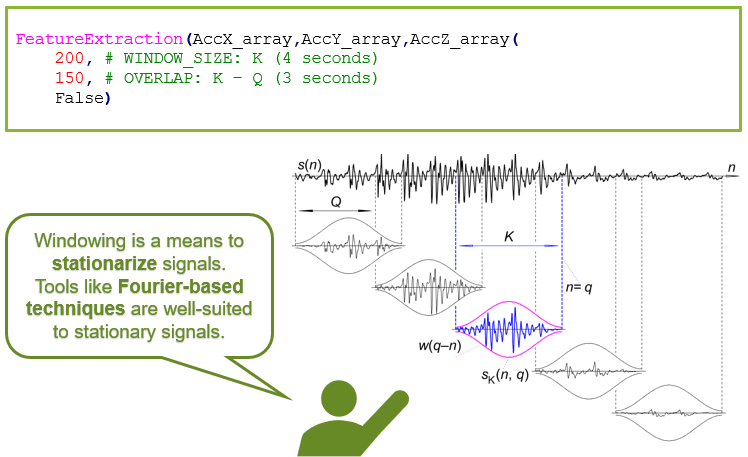


In [9]:
import numpy as np
from oct2py import octave

def FeatureExtraction(AccX_array, AccY_array, AccZ_array, window_size=200, overlap=150, debug=False):
    """
    Extract MFCC (x10 x3axis) and functionals (mean & std) features from a sample of the 3D acceleromenter.

      :param AccX_array: Array with all the timesteps tht we have for the X component of the acceleromenter signal. (200 timesteps in our case)
      :param AccY_array: Array with all the timesteps tht we have for the Y component of the acceleromenter signal. (200 timesteps in our case)
      :param AccZ_array: Array with all the timesteps tht we have for the Z component of the acceleromenter signal. (200 timesteps in our case)
      :param window_size: Size of the window to apply to the raw signals (in number of samples). Default value in our case: 150 samples = 3 seconds (150 samples/50samplespsec)
      :param overlap: Overlap to apply between windows (in number of samples).  Default value in our case: 100 samples = 2 seconds (100 samples/50samplespsec)
    """
    aux_AccX_array = AccX_array[np.newaxis, :].T
    aux_AccY_array = AccY_array[np.newaxis, :].T
    aux_AccZ_array = AccZ_array[np.newaxis, :].T
    mfcc_plp = octave.calcula_features_mfcc_plp_online_new(aux_AccX_array, aux_AccY_array, aux_AccZ_array, window_size, overlap, False)
    
    functionals = [np.mean(aux_AccX_array), np.mean(aux_AccY_array), np.mean(aux_AccZ_array),
                   np.std(aux_AccX_array), np.std(aux_AccY_array), np.std(aux_AccZ_array)]

    if debug:
        print("\n[FeatureExtraction]\n")
        #print(aux_AccX_array)
        #print(aux_AccY_array)
        #print(aux_AccZ_array)
        print("\n[Result FeatureExtraction]\n")
        #print(result)
        print(functionals)
    res = np.append((np.asarray(mfcc_plp, dtype=float)),(np.asarray(functionals, dtype=float)))
    return res

def GetFeatureNames():
  """
    Return a list with the names of features extracted by FeatureExtraction
  """
  name_cols = []
  for i in range(1,37):
    if(i in range(1,11)):
      feature_name = "X_MFCC_param"+str(i)
    elif(i in range(11,21)):
      feature_name = "Y_MFCC_param"+str(i)
    elif(i in range(21,31)):
      feature_name = "Z_MFCC_param"+str(i)
    elif(i in [31]):
      feature_name = "X_mean_param"
    elif(i in [32]):
      feature_name = "Y_mean_param"
    elif(i in [33]):
      feature_name = "Z_mean_param"
    elif(i in [34]):
      feature_name = "X_std_param"
    elif(i in [35]):
      feature_name = "Y_std_param"
    elif(i in [36]):
      feature_name = "Z_std_param"
    name_cols.append(feature_name)
  return name_cols

## LSTM Functions

The fourth group is composed by the neccesary functions for preparing dataset, an LSTM model (architecutre definition, training, evaluation...)
Do you feel curiosity about how LSTM works?? Check this!: http://colah.github.io/posts/2015-08-Understanding-LSTMs/   || https://www.youtube.com/watch?v=QciIcRxJvsM&ab_channel=CodeEmporium

Run it now to have the functions ready for applying them later. 

In [10]:
import pandas as pd
import numpy as np
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

def PrepareData(df_csv, num_steps = 200, dimensions=3):
  """
    Prepare dataset for introducing data into LSTM. One important characteristic of LSTM is that they are temporal models, so data must follow a specific shape:
    (num_samples, num_steps, num_attributes), in our case for the training set will be: (4.800, 200, 3). We use 200 timesteps (4 secs.) because each sample has this temporal resoulution, number 3 makes reference to
    the number of attributes, in our case 3 becasue we introduce information about the 3-axis of the accelerometer signal. 
    This function results the dataset as X and the labels in the array y.
    :param df_csv: Dataframe with the set to convert
    :param num_steps: Number of timesteps
    :param dimensions: Number of attributes
  """
  df_csv.drop(columns='user')
  X_pre = df_csv.iloc[:,:-2].values
  y_pre = df_csv.iloc[:,-2]
  y_pre_dum= pd.get_dummies(y_pre).values
  X = []
  y = []
  for j in range (X_pre.shape[0]):   #row
      for i in range (num_steps):    #column
          X.append([X_pre[j,i], X_pre[j,i+num_steps], X_pre[j, i+(2*num_steps)]])
  data = np.asarray(X, dtype=np.float64)
  y=y_pre_dum 
  X = np.reshape(X,newshape=(-1, num_steps, dimensions))
  return X, y

def CreateLSTM(neurons_first_layer = 200, n_steps = 200, dimension = 3, loss='categorical_crossentropy',
               optimizer='rmsprop', metrics=['accuracy']):
  """
    Create LSTM model
    :param neurons_first_layer: Number of neurons of the first layer. This number can be different from the number of timesteps.
    :param n_steps: Number of timesteps of the input.
    :param dimensions: Number of attributes of the input
    :param loss: Loss function that the network will use during training for reducing its error
    :param optimez: Optimizer to use for the update rule and the training process
    :param metrics: List with the metrics to print during training
  """
  model_lstm = Sequential()
  model_lstm.add(LSTM(neurons_first_layer, input_shape=(n_steps, dimension), return_sequences=False))
  model_lstm.add(Dense(4, activation='softmax'))
  model_lstm.compile(loss=loss, optimizer=optimizer, metrics=metrics)
  return model_lstm

def EvalLSTM(y_labels, y_pred):
  """
     Eval LSTM model. Print accuracy and confussion matrix.
    :param y_labels: Original labels of the set.
    :param y_pred: Predictions of the labels for the set.
  """
  y_test_df = pd.DataFrame({0:y_labels[:,0],1:y_labels[:,1],2:y_labels[:,2],3:y_labels[:,3]})
  y_test_df_idx=y_test_df.idxmax(axis=1)

  print(confusion_matrix(y_test_df_idx, y_pred))
  print(classification_report(y_test_df_idx, y_pred))
  print('Accuracy %0.4f' % accuracy_score(y_test_df_idx, y_pred))


def CalculateCI(num_samples, accuracy):
  """
    Calculate confidence interval for a confidence of 95%
    :param num_samples: Number of samples for the set to evaluate
    :param accuracy: Accuracy of the model
  """
  return 1.96*(np.sqrt(((100-accuracy)*(accuracy))/num_samples))

def Recognize_LSTM(trained_LSTM,test_parameters,test_labels):
  """
    Make predictions of full dataset and print information of each sample results. 
    :param trained_classifier: Classifier built and trained(see TrainModel)
    :param test_dataset: Dataset loaded in Weka format with data to test (see LoadDatasetAsCSV or LoadDataset). 
  """
  y_pred = trained_LSTM.predict(test_parameters)
  print("# - actual - predicted - error - class distribution")
  for index in range(0,len(test_labels)):
    pred = Convert2nominal_pingPong(np.argmax(y_pred[index],axis=-1)+1)
    true_val = Convert2nominal_pingPong(np.argmax(test_labels[index],axis=-1)+1)
    print("%d - %s - %s - %s  - %s" %
              (index+1,
              true_val,
              pred,
              "yes" if pred != true_val else "no",
              str(y_pred[index])))


# Baseline

It is time to start with the interesting part!


Once the environment is up, we must download the datasets that we are going to use in this practice for implementing the models of the 3 commented scenarios.


## Download datasets

Next fragment letS you download training and test sets in CSV format. 





In [77]:
#Download datasets (and save them for loading them later) - CSV
!pip install pandas
import pandas as pd

def DownloadDS():
  #link_train_csv = "https://drive.google.com/file/d/11cKYLGK6kcFYLlR0jmG6EDklRQQvY_e5/view?usp=sharing" # 0-7
  #link_train_csv = "https://drive.google.com/file/d/1eq4aKd8HhecL7WBcNu1ghq2_9PsgTam5/view?usp=sharing" # 0-3, 8-11
  link_train_csv = "https://drive.google.com/file/d/18-RJ9PKMCfHBOHHd_DRhAa2BjGjW1KuM/view?usp=sharing" # 4-11
  
  #link_train_csv = "https://drive.google.com/file/d/1m0zKinURRSkrI3WTql5__1I_z7CYDNNb/view?usp=sharing"
  id_train_csv = link_train_csv.split('/d/')[1].split("/")[0]
  print (id_train_csv) # Verify that id is ok

  downloaded = drive.CreateFile({'id':id_train_csv}) 
  downloaded.GetContentFile('df_train.csv')  
  df_train_csv = pd.read_csv('df_train.csv', sep=" ", header=None)

  #link_test_csv = "https://drive.google.com/file/d/1o8F7XfxfSQYMioeluOQ05WjWA3YR-48e/view?usp=sharing" #8-11
  #link_test_csv = "https://drive.google.com/file/d/17itkcGDRMtKABO3A-EVNnUYREU0Kz38c/view?usp=sharing" #4-7
  link_test_csv = "https://drive.google.com/file/d/1lstZNOfbibRMXls5Qnkigjc8LREGVlog/view?usp=sharing" #0-3

  #link_test_csv = "https://drive.google.com/file/d/1rg1c5yA53H1S3pO_ur8CE6Q0SnzTtjsu/view?usp=sharing"
  id_test_csv = link_test_csv.split('/d/')[1].split("/")[0]
  print (id_test_csv) # Verify that id is ok

  downloaded = drive.CreateFile({'id':id_test_csv}) 
  downloaded.GetContentFile('df_test.csv')  
  df_test_csv = pd.read_csv('df_test.csv', sep=" ", header=None)

  col_names = ["param"+str(i) for i in range(1,601)]
  col_names = col_names+["class", "user"]

  df_train_csv.columns = col_names
  df_test_csv.columns = col_names
  return df_train_csv, df_test_csv


df_train_csv, df_test_csv = DownloadDS()

18-RJ9PKMCfHBOHHd_DRhAa2BjGjW1KuM
1lstZNOfbibRMXls5Qnkigjc8LREGVlog


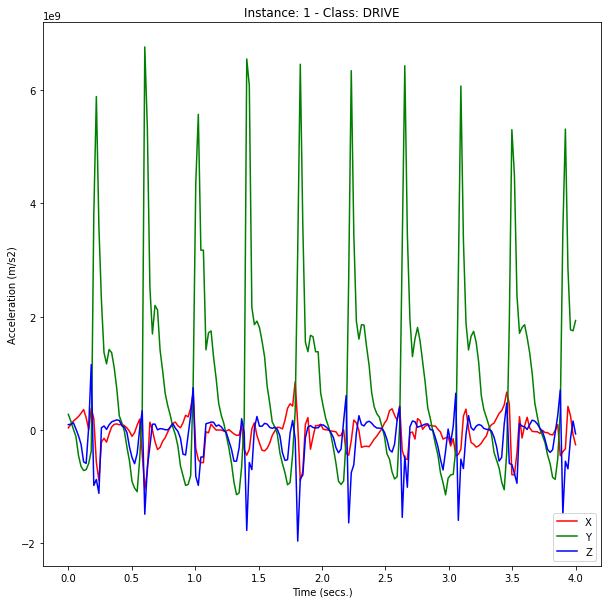

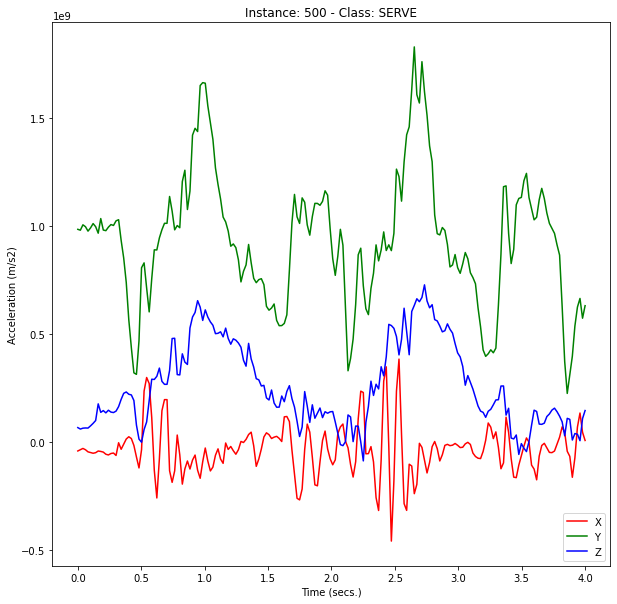

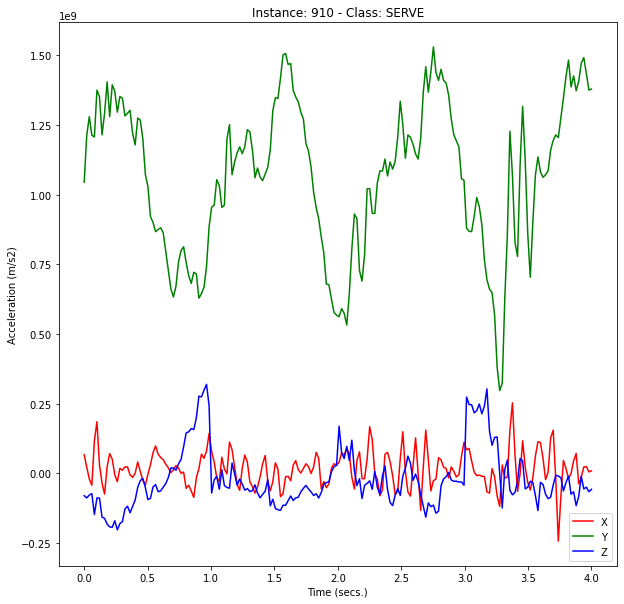

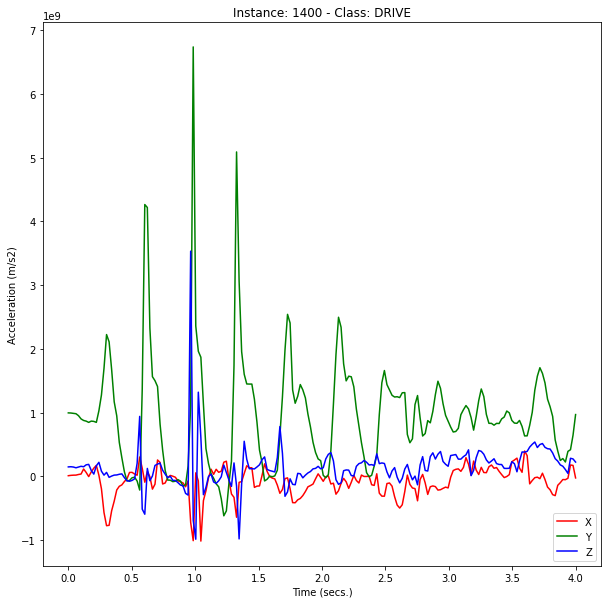

In [78]:
# PLOT DATA:
#PLOT CSVs SINGLE SAMPLE
plot_sample(1, df_train_csv) #DRIVE
plot_sample(500, df_train_csv) #BACKHAND
plot_sample(910, df_train_csv) #SERVE
plot_sample(1400, df_train_csv) #LOB


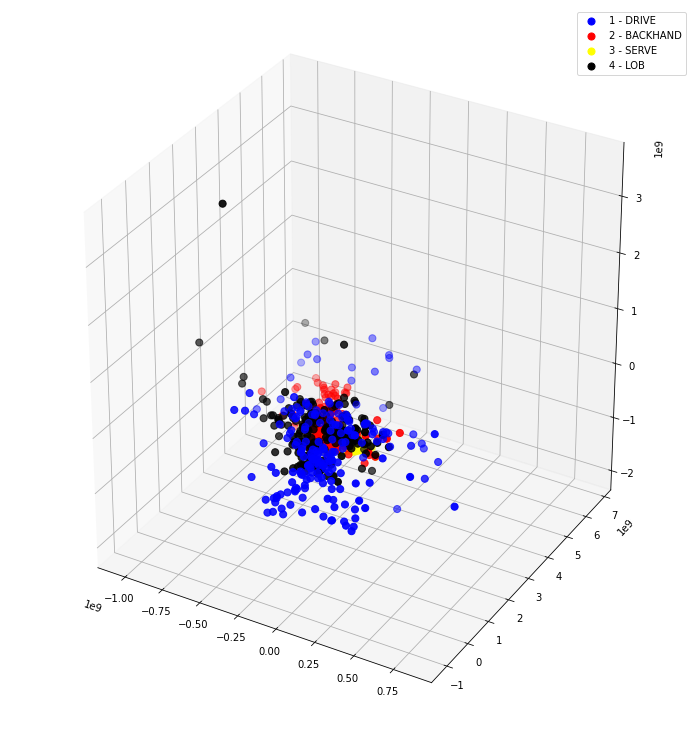

In [79]:
PlotScatter_train(df_train_csv)

## Raw data + Decision Tree Scenario

This section englobes the experiments of the first scenario. 

At the beginning, we will adapt the downloaded datasets to Weka expected format by transforming the labels from numerical type o nominal and appending them at the end of the attributes list. 

After that, we will build and train a Decision Tree with the raw accelerometer data. We won’t process it in this part for having a reference performance before to include more complex proceedings. 

At the end of this part, we will evaluate the model in terms of accuracy, and show the returned predictions of the trained model in our test set. 


In [80]:
#PREPARE DATA
import weka.core.jvm as jvm
#Create new instance of java virtual machine for running weka
jvm.start(max_heap_size="1200m")

#Format files for Weka function
#Convert class data from numeric to nominal
df_train_csv_norminal_labels = df_train_csv.copy()
df_train_csv_norminal_labels["labels"] = df_train_csv_norminal_labels["class"].replace(1, "DRIVE").replace(2, "BACKHAND").replace(3,"SERVE").replace(4,"LOB")
#Remove numeric class and user column
df_train_csv_norminal_labels = df_train_csv_norminal_labels.drop(["class"], axis=1)
df_train_csv_norminal_labels = df_train_csv_norminal_labels.drop(["user"], axis=1)
#Save dataframe
df_train_csv_norminal_labels.to_csv('df_train_nominal.csv', sep = ",", index=False, header=True)

#Fortmat test as we did in training file
df_test_csv_norminal_labels = df_test_csv.copy()
df_test_csv_norminal_labels["labels"] = df_test_csv_norminal_labels["class"].replace(1, "DRIVE").replace(2, "BACKHAND").replace(3,"SERVE").replace(4,"LOB")
df_test_csv_norminal_labels = df_test_csv_norminal_labels.drop(["class"], axis=1)
df_test_csv_norminal_labels = df_test_csv_norminal_labels.drop(["user"], axis=1)
df_test_csv_norminal_labels.to_csv('df_test_nominal.csv', sep = ",", index=False, header=True)

#Load datasets as CSV
dataset_train_weka = LoadDatasetAsCSV('df_train_nominal.csv', debug = False)
dataset_test_weka = LoadDatasetAsCSV('df_test_nominal.csv', debug = False)

print('Sample size training: ', dataset_train_weka.num_instances)
print('Sample size testing: ', dataset_test_weka.num_instances)  

INFO:weka.core.jvm:JVM already running, call jvm.stop() first


Sample size training:  3200
Sample size testing:  1600


In [81]:
#DATA GENERATED
df_test_csv_norminal_labels

,param1,param2,param3,param4,param5,param6,param7,param8,param9,param10,param11,param12,param13,param14,param15,param16,param17,param18,param19,param20,param21,param22,param23,param24,param25,param26,param27,param28,param29,param30,param31,param32,param33,param34,param35,param36,param37,param38,param39,param40,...,param562,param563,param564,param565,param566,param567,param568,param569,param570,param571,param572,param573,param574,param575,param576,param577,param578,param579,param580,param581,param582,param583,param584,param585,param586,param587,param588,param589,param590,param591,param592,param593,param594,param595,param596,param597,param598,param599,param600,labels
0,62234635,46675980,35186508,48351525,56489903,31596047,-2393640,-100054148,-159177056,-367423741,-498595178,-560111746,-483754623,-461015064,-413142243,-310455108,-381785585,-430376473,-406679433,-313088110,-124708641,-43803612,3829824,61995272,191969922,386572846,605351536,605351536,-953865528,-931604652,-374604648,-240321455,-268566416,-19388483,70851743,94548775,72287928,47633436,52660079,67021919,...,119681994,72048565,38058876,24654492,87846587,185507097,-125426737,-569686327,39016332,-56968633,-255640736,-92633863,30159863,-26090675,5266008,74442203,116570267,115852170,77075205,49069618,-29441772,-5505372,15079932,50266437,72766655,-40691877,-181916644,-149363133,-253965187,-53378172,-34947141,-57447359,-21542760,75639026,120639454,152235505,163964332,153432327,112740443,DRIVE
1,-424152989,-317157304,-290109166,-213273317,-70612380,3590460,73963477,153671683,197714666,264018481,407397529,141224759,-921790743,-634553934,-403567691,-244869361,-321465854,-63431458,47633436,122315003,30877954,33510959,29920499,42606789,75399656,111543620,53378172,-120160728,-527318864,-1046499340,-580697044,-58404815,157022781,-74681567,-430615829,-557000033,-429897732,-313806206,-182156000,-182156000,...,14122476,-104123335,-112979806,-70851743,295853909,-303752913,-402131498,-176889997,-97660510,-48112162,22978944,-30399228,-28723679,10053288,39495058,82819941,112261717,136676839,118485179,82101851,29202407,64628281,194602924,-386812202,-462451228,-5505372,-301119912,-175693174,-35665234,-67021919,-66303829,48351525,49787711,100054148,150081230,161810057,141464115,129495917,120400091,DRIVE
2,-111304257,-148166310,-111304257,58165452,119203268,34947141,-25372584,-53856898,-61037820,35904601,51941986,9095832,-236730987,-481361007,-766443497,-806656670,239364,126384190,-17952301,-417211438,-503382469,-402370883,-342769249,-193645471,-94788146,37819513,87846587,152474860,208486041,269045127,251332186,16994845,-703969506,-500270756,-345162894,-32314140,-215427592,-139549210,118724542,124469270,...,-501946275,-125666093,-256598218,-159655782,-216385045,-77314568,-65346370,-57686722,56011173,211837139,222608514,215188236,126384190,65825096,3829824,-17473571,46436613,244390635,-615165444,-398062333,73006018,-154629136,-320269017,9095832,-51941986,-60559090,68218741,112022346,141703485,148645037,104841432,41409970,24175763,-2154276,-12925656,23697036,-208007315,35186508,-55771810,DRIVE
3,-976365731,-299923074,95266872,327449953,-430376473,-714262184,-541920064,-348274607,-194602924,-55053721,22500216,39495058,42367426,48830255,54096261,111782983,167315430,208486041,-86171038,-773624404,-406440077,-206810492,-142900308,-245108731,3590460,178804902,128059738,61995272,28244951,2633004,-3111732,40213151,27287495,-90479588,-274311130,-576388523,-1071153891,-652266905,32074777,277901612,...,-143139664,-93112597,-285561260,-123990544,-59840997,-111543620,-70612380,-2633004,113697895,146730132,221890417,224044692,126623560,63670821,2154276,-6223464,-56250540,-98857333,-538329639,-179283628,-35186508,-337263861,-223565966,-74442203,-77075205,-37101420,32553503,145533309,234097986,240082085,170427157,140985389,84016763,49308985,-5744736,-155825958,-11010744,-175453804,-189576292,DRIVE
4,-746336910,-428940280,-71569832,-115373444,-14361840,139788566,66543193,-30638591,-57686722,-1436184,6462828,-3

In [82]:
#TRAIN NEW MODEL FROM RAW DATA

print('Classifying on: ', dataset_test_weka.class_attribute)
#Create model architecture:
options_NB = [""] 
model_arquitecture = CreateClassifier(classname="weka.classifiers.bayes.NaiveBayes", options=options_NB)

#Train model
!cd content; mkdir models
out_path_model = "models/trained_NaivesBayes.model"
trained_model = TrainModel(dataset_train_weka, model_arquitecture, out_path_model)                                 

Classifying on:  @attribute labels {DRIVE,BACKHAND,SERVE,LOB}
/bin/bash: line 0: cd: content: No such file or directory
mkdir: cannot create directory ‘models’: File exists

[TrainedModel]


Naive Bayes Classifier

                         Class
Attribute                DRIVE        BACKHAND           SERVE             LOB
                        (0.25)          (0.25)          (0.25)          (0.25)
param1
  mean           -68528074.6937  -37309776.0092  -37832380.4468  -26243104.4386
  std. dev.      452122995.6009  202346798.5243  111377300.7246  107622475.2211
  weight sum                800             800             800             800
  precision        3344668.4006    3344668.4006    3344668.4006    3344668.4006

param2
  mean           -48433762.8909  -38776937.3868  -38084873.7992  -25309754.0606
  std. dev.      419287138.5499  207413928.7993  111796238.8523  107095892.6919
  weight sum                800             800             800             800
  precision         2

In [83]:
# EVALUATE MODEL
EvalClassifier(trained_model, dataset_train_weka, dataset_test_weka)

--------RESULTS IN TRAINING----------

Correctly Classified Instances        2936               91.75   %
Incorrectly Classified Instances       264                8.25   %
Kappa statistic                          0.89  
Mean absolute error                      0.0417
Root mean squared error                  0.2019
Relative absolute error                 11.1214 %
Root relative squared error             46.6279 %
Total Number of Instances             3200     

--------RESULTS IN TEST----------

Correctly Classified Instances        1392               87      %
Incorrectly Classified Instances       208               13      %
Kappa statistic                          0.8267
Mean absolute error                      0.0653
Root mean squared error                  0.253 
Relative absolute error                 17.4174 %
Root relative squared error             58.4226 %
Total Number of Instances             1600     



In [84]:
#SEE PREDICTIONS:
Recognize(trained_model, dataset_test_weka)

# - actual - predicted - error - class distribution
1 - DRIVE - DRIVE - no  - [1.0, 0.0, 0.0, 0.0]
2 - DRIVE - DRIVE - no  - [1.0, 0.0, 0.0, 0.0]
3 - DRIVE - DRIVE - no  - [1.0, 0.0, 0.0, 0.0]
4 - DRIVE - DRIVE - no  - [1.0, 0.0, 0.0, 0.0]
5 - DRIVE - DRIVE - no  - [1.0, 0.0, 0.0, 0.0]
6 - DRIVE - DRIVE - no  - [1.0, 0.0, 0.0, 0.0]
7 - DRIVE - DRIVE - no  - [1.0, 0.0, 0.0, 0.0]
8 - DRIVE - DRIVE - no  - [1.0, 0.0, 0.0, 0.0]
9 - DRIVE - DRIVE - no  - [1.0, 0.0, 0.0, 0.0]
10 - DRIVE - DRIVE - no  - [1.0, 0.0, 0.0, 0.0]
11 - DRIVE - DRIVE - no  - [1.0, 0.0, 0.0, 0.0]
12 - DRIVE - DRIVE - no  - [1.0, 0.0, 0.0, 0.0]
13 - DRIVE - DRIVE - no  - [1.0, 0.0, 0.0, 0.0]
14 - DRIVE - DRIVE - no  - [1.0, 0.0, 0.0, 0.0]
15 - DRIVE - DRIVE - no  - [1.0, 0.0, 0.0, 0.0]
16 - DRIVE - DRIVE - no  - [1.0, 0.0, 0.0, 0.0]
17 - DRIVE - DRIVE - no  - [1.0, 0.0, 0.0, 0.0]
18 - DRIVE - DRIVE - no  - [1.0, 0.0, 0.0, 0.0]
19 - DRIVE - DRIVE - no  - [1.0, 0.0, 0.0, 0.0]
20 - DRIVE - DRIVE - no  - [1.0, 0.0, 0.0, 0.

## Feature Extraction + Decision Tree Scenario

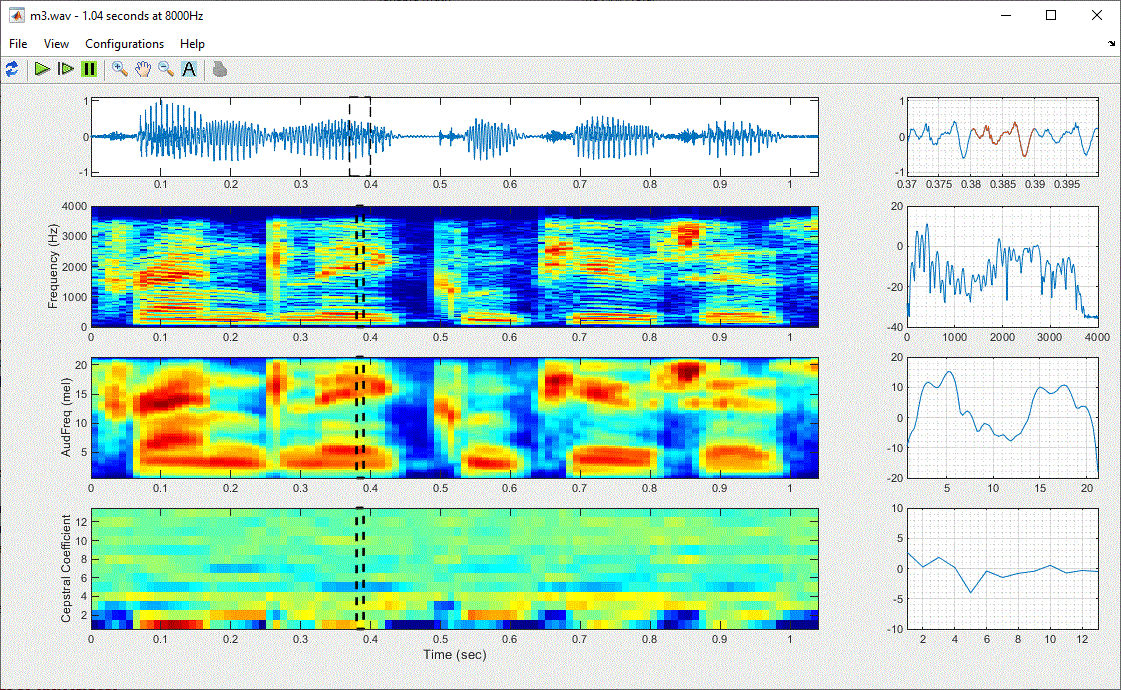
Source: https://homes.esat.kuleuven.be/~spchlab/H02A6/lab/session2/mfcc.html

Ref.  https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html

In this section, we will introduce the second scenario. 

In this case, we will include a module whose function consists of extracting features from raw data. Among these features, we have Mel Frequency Cepstral Coeﬃcients (MFCC) that are usually employed in speech for representing information in a more compact way according to human auditive system. We will employ them in this new problem for simplicity(they are easy to extract), because MFCCs let work with much less information than raw signals and because they return uncorrelated features. 

One of the main advantages of using features extracted from raw signals is that they compact information, reducing the number of input features and thus, the complexity of the models. Additionally, they are usually tailored to the problem, hence, we know that they will solve the problem with certain success.  However, discovering a good set of features is usually a time-consuming task that requires proposing new possible features, implementing them, and comparing them to find an optimal combination. 

In summary, in this section we will extract features from accelerometer signals and repeat the previous section steps for training and evaluating the features-based J48-Decision-Tree.


**Note:** As the extraction process takes some time, it is recommended to download generated features datasets (mfcc_features_test.csv and mfcc_features_train.csv) and upload them later if you need to stop and close your current Collab session, since they won't be available in a new session.

In [85]:
#GENERATE ARRAYS WITH EACH COMPONENT DATA
AccX_array_train = df_train_csv.loc[:, 'param1':'param200']
AccY_array_train = df_train_csv.loc[:, 'param201':'param400']
AccZ_array_train = df_train_csv.loc[:, 'param401':'param600']
labels_train = df_train_csv.loc[:,"class"]
users_train = df_train_csv.loc[:,"user"]

AccX_array_test = df_test_csv.loc[:, 'param1':'param200']
AccY_array_test = df_test_csv.loc[:, 'param201':'param400']
AccZ_array_test = df_test_csv.loc[:, 'param401':'param600']
labels_test = df_test_csv.loc[:,"class"]
users_test = df_test_csv.loc[:,"user"]

In [86]:
#CONVERT LABELS FROM NUMERIC TO NOMINAL
labels_train_new = labels_train.replace(1, "DRIVE").replace(2, "BACKHAND").replace(3,"SERVE").replace(4,"LOB")
labels_test_new = labels_test.replace(1, "DRIVE").replace(2, "BACKHAND").replace(3,"SERVE").replace(4,"LOB")

In [87]:
# GENERATE MFCC FEATURES OF TRAINING SET
#Add files to octave
octave_path = '/usr/local/lib/octave/'
octave.addpath(octave_path)

#Extract MFCC features from raw data: 
#sampling freq of accelerometer: 50 samples/sec
window_size = 200 # 50 samples/sec * 4 secs
overlap = 150 # 50 samples/sec * 3 secs
name_cols = GetFeatureNames()

mfcc_features_train = pd.DataFrame([], columns=name_cols)
for index in range(len(AccX_array_train)):
  if(index%200==0):
    print("[TRAIN] Processing ", str(index) ,"of", str(len(AccX_array_train)))
  features_train = FeatureExtraction(np.append(AccX_array_train.values[index],[0]), np.append(AccY_array_train.values[index],[0]), np.append(AccZ_array_train.values[index],[0]), window_size, overlap, False)
  mfcc_features_train = mfcc_features_train.append(pd.DataFrame([features_train],columns=name_cols))

#Append user id and class(as a nominal attribute)
mfcc_features_train["class"] = labels_train_new.values
mfcc_features_train.reset_index(drop=True, inplace=True)

[TRAIN] Processing  0 of 3200
[TRAIN] Processing  200 of 3200
[TRAIN] Processing  400 of 3200
[TRAIN] Processing  600 of 3200
[TRAIN] Processing  800 of 3200
[TRAIN] Processing  1000 of 3200
[TRAIN] Processing  1200 of 3200
[TRAIN] Processing  1400 of 3200
[TRAIN] Processing  1600 of 3200
[TRAIN] Processing  1800 of 3200
[TRAIN] Processing  2000 of 3200
[TRAIN] Processing  2200 of 3200
[TRAIN] Processing  2400 of 3200
[TRAIN] Processing  2600 of 3200
[TRAIN] Processing  2800 of 3200
[TRAIN] Processing  3000 of 3200


In [88]:
# GENERATE MFCC FEATURES OF TEST SET
#Add files to octave
octave_path = '/usr/local/lib/octave/'
octave.addpath(octave_path)


#Extract MFCC features from raw data: 
#sampling freq of accelerometer: 50 samples/sec
window_size = 200 # 50 samples/sec * 3 secs
overlap = 150 # 50 samples/sec * 2 secs
name_cols = GetFeatureNames()

mfcc_features_test = pd.DataFrame([], columns=name_cols)
for index in range(len(AccX_array_test)):
  if(index%200==0):
    print("[TEST] Processing ", str(index) ,"of", str(len(AccX_array_test)))
  features_test = FeatureExtraction(np.append(AccX_array_test.values[index],[0]), np.append(AccY_array_test.values[index],[0]), np.append(AccZ_array_test.values[index],[0]), window_size, overlap, False)
  mfcc_features_test = mfcc_features_test.append(pd.DataFrame([features_test],columns=name_cols))

#Append user id and class(as a nominal attribute)
#mfcc_features_test["user"] = users_test.values
mfcc_features_test["class"] = labels_test_new.values
mfcc_features_test.reset_index(drop=True, inplace=True)

[TEST] Processing  0 of 1600
[TEST] Processing  200 of 1600
[TEST] Processing  400 of 1600
[TEST] Processing  600 of 1600
[TEST] Processing  800 of 1600
[TEST] Processing  1000 of 1600
[TEST] Processing  1200 of 1600
[TEST] Processing  1400 of 1600


In [89]:
mfcc_features_test

,X_MFCC_param1,X_MFCC_param2,X_MFCC_param3,X_MFCC_param4,X_MFCC_param5,X_MFCC_param6,X_MFCC_param7,X_MFCC_param8,X_MFCC_param9,X_MFCC_param10,Y_MFCC_param11,Y_MFCC_param12,Y_MFCC_param13,Y_MFCC_param14,Y_MFCC_param15,Y_MFCC_param16,Y_MFCC_param17,Y_MFCC_param18,Y_MFCC_param19,Y_MFCC_param20,Z_MFCC_param21,Z_MFCC_param22,Z_MFCC_param23,Z_MFCC_param24,Z_MFCC_param25,Z_MFCC_param26,Z_MFCC_param27,Z_MFCC_param28,Z_MFCC_param29,Z_MFCC_param30,X_mean_param,Y_mean_param,Z_mean_param,X_std_param,Y_std_param,Z_std_param,class
0,168.937167,-3.175450,-6.807066,-3.847899,-3.358274,-3.887749,-2.354788,-2.102415,-0.967893,-0.875164,175.541105,-5.232835,-5.960850,-3.145106,-4.410417,-2.252772,0.227720,2.341734,4.398423,4.726138,167.428960,-4.775782,-3.328686,-3.606022,-5.238850,-3.366684,-2.804934,0.229227,0.739366,0.816249,-1.466384e+08,9.480422e+08,-1.316026e+07,3.100649e+08,1.172198e+09,1.912041e+08,DRIVE
1,169.517284,-2.929295,-6.500292,-3.737072,-3.225328,-4.428382,-1.915819,-2.268567,-0.893812,-1.859132,176.343788,-4.435782,-5.404272,-3.306279,-5.188216,-3.404898,-0.715990,1.401405,3.695078,3.586446,167.369662,-4.387761,-3.322305,-3.542988,-5.137328,-2.795320,-2.658661,0.425905,0.789428,0.934119,-1.349644e+08,9.361121e+08,-2.476762e+07,2.844396e+08,1.179624e+09,1.893319e+08,DRIVE
2,169.855617,-2.574634,-5.647515,-3.153306,-3.180688,-3.398579,-2.218823,-1.604142,-0.599442,-1.135386,177.238496,-3.826634,-5.329801,-3.638534,-5.243120,-3.982302,-1.574347,0.359071,1.930293,1.320387,166.455132,-4.069169,-4.341695,-4.667955,-5.852517,-3.824412,-2.550512,-0.582169,-0.395379,-1.234691,-1.332221e+08,9.311224e+08,-2.240375e+07,2.802925e+08,1.122243e+09,1.803641e+08,DRIVE
3,169.557019,-2.515214,-5.646675,-3.978115,-3.044301,-4.190661,-2.694941,-3.761588,-1.686018,-2.122091,177.828190,-3.171235,-5.082631,-2.884320,-5.386967,-3.681223,-1.443861,-0.712942,-0.024454,-0.160889,166.499411,-4.254248,-3.854080,-4.888343,-6.908296,-5.162056,-3.582552,-0.999078,-0.510547,-2.815839,-1.414665e+08,9.504894e+08,-1.333174e+07,2.890089e+08,1.090071e+09,1.611530e+08,DRIVE
4,170.481022,-2.170441,-5.624542,-3.642947,-2.422338,-3.319771,-1.139962,-2.739746,-1.005254,-2.004561,177.426111,-3.039236,-5.456586,-2.750090,-5.610048,-2.996474,-0.427346,-0.578188,-0.586216,-0.259952,166.023029,-4.254545,-3.779594,-4.935641,-6.956515,-4.430558,-2.738967,-0.856405,-0.262988,-2.010822,-1.370079e+08,9.414901e+08,-1.814046e+07,2.776131e+08,1.126305e+09,1.622648e+08,DRIVE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,161.931745,-0.609033,-3.710595,-2.997384,-2.853942,-2.901654,-0.915724,0.206646,-1.102966,-0.677802,163.256140,-1.553939,-3.633386,-0.653186,-1.054533,-2.167868,-0.267102,-0.036321,1.077357,0.339224,160.037908,-1.447252,-3.600403,-3.557393,-4.278937,-2.183668,-2.976349,-2.854316,-2.701472,-3.126004,5.764981e+06,9.989029e+08,9.312569e+05,8.331199e+07,1.058795e+08,6.774327e+07,LOB
1596,161.769439,-1.264147,-4.080294,-3.261832,-2.522544,-2.199251,-0.503592,-0.413677,-1.346298,-1.224214,163.240972,-0.917554,-3.380507,-0.843359,-0.700512,-1.829539,-0.227417,-0.265583,-0.225608,-1.711764,160.996631,-0.947087,-3.041789,-3.577482,-3.797644,-2.716606,-2.271814,-1.526897,-2.206257,-2.323898,1.285897e+07,9.856390e+08,2.726368e+07,8.967353e+07,1.123774e+08,7.968705e+07,LOB
1597,161.229701,-1.466560,-4.283624,-2.650764,-1.998315,-2.667203,-2.527130,-3.256790,-1.158912,-2.015997,162.925727,-0.645708,-3.794631,-1.311531,-0.387111,-1.721834,-0.505523,-1.166355,0.611868,0.287676,159.905320,-0.744054,-1.963177,-2.278851,-2.889936,-2.141888,-3.294807,-1.206570,-0.197178,-1.353075,3.676202e+07,9.697743e+08,4.378932e+07,9.389028e+07,1.123586e+08,8.969953e+07,LOB
1598,161.028160,-1.346561,-4.627890,-3.938633,-1.940614,-0.233315,-1.595813,-1.579386,-1.184499,-3.555842,163.256799,-0.456072,-3.966044,-1.664487,-0.177789,-1.706755,-0.701755,-2.526574,0.931972,1.706200,160.465951,-0.88

0.CLASS:SERVE
1.CLASS:SERVE
2.CLASS:SERVE
3.CLASS:SERVE
4.CLASS:SERVE
5.CLASS:SERVE
6.CLASS:SERVE
7.CLASS:SERVE
8.CLASS:SERVE
9.CLASS:SERVE
10.CLASS:SERVE
11.CLASS:SERVE
12.CLASS:SERVE
13.CLASS:SERVE
14.CLASS:SERVE
15.CLASS:SERVE
16.CLASS:SERVE
17.CLASS:SERVE
18.CLASS:SERVE
19.CLASS:SERVE
20.CLASS:SERVE
21.CLASS:SERVE
22.CLASS:SERVE
23.CLASS:SERVE
24.CLASS:SERVE
25.CLASS:SERVE
26.CLASS:SERVE
27.CLASS:SERVE
28.CLASS:SERVE
29.CLASS:SERVE
30.CLASS:SERVE
31.CLASS:SERVE
32.CLASS:SERVE
33.CLASS:SERVE
34.CLASS:SERVE
35.CLASS:SERVE
36.CLASS:SERVE
37.CLASS:SERVE
38.CLASS:SERVE
39.CLASS:SERVE
40.CLASS:SERVE
41.CLASS:SERVE
42.CLASS:SERVE
43.CLASS:SERVE
44.CLASS:SERVE
45.CLASS:SERVE
46.CLASS:SERVE
47.CLASS:SERVE
48.CLASS:SERVE
49.CLASS:SERVE
50.CLASS:LOB
51.CLASS:LOB
52.CLASS:LOB
53.CLASS:LOB
54.CLASS:LOB
55.CLASS:LOB
56.CLASS:LOB
57.CLASS:LOB
58.CLASS:LOB
59.CLASS:LOB
60.CLASS:LOB
61.CLASS:LOB
62.CLASS:LOB
63.CLASS:LOB
64.CLASS:LOB
65.CLASS:LOB
66.CLASS:LOB
67.CLASS:LOB
68.CLASS:LOB
69.CLASS:LOB


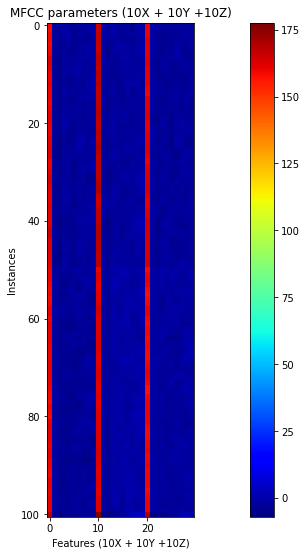

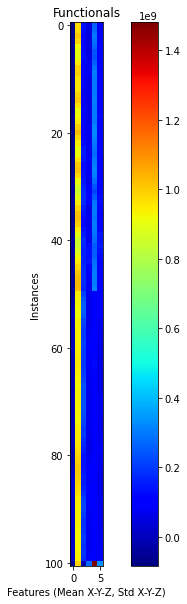

In [90]:
import matplotlib.pyplot as plt
import numpy as np
#PLOT EXTRACTED MFCC SAMPLES
df_csv = mfcc_features_test
ini_sample = 100
end_sample = 200
#MFCC
MFCC_x = df_csv.loc[ini_sample:end_sample, 'X_MFCC_param1':'X_MFCC_param10'].values.astype(float)
MFCC_y = df_csv.loc[ini_sample:end_sample, 'Y_MFCC_param11':'Y_MFCC_param20'].values.astype(float)
MFCC_z = df_csv.loc[ini_sample:end_sample, 'Z_MFCC_param21':'Z_MFCC_param30'].values.astype(float)
#FUNCTIONALS:
functionals_x = df_csv.loc[ini_sample:end_sample, ['X_mean_param','X_std_param']].values.astype(float)
functionals_y = df_csv.loc[ini_sample:end_sample, ['Y_mean_param','Y_std_param']].values.astype(float)
functionals_z = df_csv.loc[ini_sample:end_sample, ['Z_mean_param','Z_std_param']].values.astype(float)
t = np.linspace(0, 4, 200)



figsize_new = (end_sample-ini_sample)
plt.figure(figsize=(max(10,(int(figsize_new/5))),max(10,(int(figsize_new/5)))))

plt.subplot(212)
plt.imshow((df_csv.loc[ini_sample:end_sample, 'X_MFCC_param1':'Z_MFCC_param30'].values.astype(float)), cmap=plt.cm.jet)
plt.title("MFCC parameters (10X + 10Y +10Z)")
plt.xlabel('Features (10X + 10Y +10Z)')
plt.ylabel('Instances')
plt.colorbar()

#PLOT FUNCTIONALS
plt.figure(figsize=(max(5,(int(figsize_new/10))),max(5,(int(figsize_new/10)))))
plt.imshow((df_csv.loc[ini_sample:end_sample, 'X_mean_param':'Z_std_param'].values.astype(float)), cmap=plt.cm.jet)
plt.title("Functionals")
plt.xlabel('Features (Mean X-Y-Z, Std X-Y-Z)')
plt.ylabel('Instances')
plt.colorbar()

#PRINT CLASS
n = 0
for i in df_csv.loc[ini_sample:end_sample, 'class'].values: 
  print(str(n)+".CLASS:" + i)
  n+=1
plt.show()


In [91]:
from google.colab import files
#DOWNLOAD MFCC DATASETS
mfcc_features_test.to_csv('mfcc_features_test.csv', sep = ",", index=False, header=True)
files.download('mfcc_features_test.csv')
mfcc_features_train.to_csv('mfcc_features_train.csv', sep = ",", index=False, header=True)
files.download('mfcc_features_train.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [92]:
#UPLOAD MFCC DATASETS
#import pandas as pd
#uploaded = files.upload()
#uploaded = files.upload()

In [93]:
mfcc_features_train = 'mfcc_features_train.csv'
mfcc_features_train = pd.read_csv(mfcc_features_train, header=0)

mfcc_features_test = 'mfcc_features_test.csv'
mfcc_features_test = pd.read_csv(mfcc_features_test,  header=0)
mfcc_features_test

,X_MFCC_param1,X_MFCC_param2,X_MFCC_param3,X_MFCC_param4,X_MFCC_param5,X_MFCC_param6,X_MFCC_param7,X_MFCC_param8,X_MFCC_param9,X_MFCC_param10,Y_MFCC_param11,Y_MFCC_param12,Y_MFCC_param13,Y_MFCC_param14,Y_MFCC_param15,Y_MFCC_param16,Y_MFCC_param17,Y_MFCC_param18,Y_MFCC_param19,Y_MFCC_param20,Z_MFCC_param21,Z_MFCC_param22,Z_MFCC_param23,Z_MFCC_param24,Z_MFCC_param25,Z_MFCC_param26,Z_MFCC_param27,Z_MFCC_param28,Z_MFCC_param29,Z_MFCC_param30,X_mean_param,Y_mean_param,Z_mean_param,X_std_param,Y_std_param,Z_std_param,class
0,168.937167,-3.175450,-6.807066,-3.847899,-3.358274,-3.887749,-2.354788,-2.102415,-0.967893,-0.875164,175.541105,-5.232835,-5.960850,-3.145106,-4.410417,-2.252772,0.227720,2.341734,4.398423,4.726138,167.428960,-4.775782,-3.328686,-3.606022,-5.238850,-3.366684,-2.804934,0.229227,0.739366,0.816249,-1.466384e+08,9.480422e+08,-1.316026e+07,3.100649e+08,1.172198e+09,1.912041e+08,DRIVE
1,169.517284,-2.929295,-6.500292,-3.737072,-3.225328,-4.428382,-1.915819,-2.268567,-0.893812,-1.859132,176.343788,-4.435782,-5.404272,-3.306279,-5.188216,-3.404898,-0.715990,1.401405,3.695078,3.586446,167.369662,-4.387761,-3.322305,-3.542988,-5.137328,-2.795320,-2.658661,0.425905,0.789428,0.934119,-1.349644e+08,9.361121e+08,-2.476762e+07,2.844396e+08,1.179624e+09,1.893319e+08,DRIVE
2,169.855617,-2.574634,-5.647515,-3.153306,-3.180688,-3.398579,-2.218823,-1.604142,-0.599442,-1.135386,177.238496,-3.826634,-5.329801,-3.638534,-5.243120,-3.982302,-1.574347,0.359071,1.930293,1.320387,166.455132,-4.069169,-4.341695,-4.667955,-5.852517,-3.824412,-2.550512,-0.582169,-0.395379,-1.234691,-1.332221e+08,9.311224e+08,-2.240375e+07,2.802925e+08,1.122243e+09,1.803641e+08,DRIVE
3,169.557019,-2.515214,-5.646675,-3.978115,-3.044301,-4.190661,-2.694941,-3.761588,-1.686018,-2.122091,177.828190,-3.171235,-5.082631,-2.884320,-5.386967,-3.681223,-1.443861,-0.712942,-0.024454,-0.160889,166.499411,-4.254248,-3.854080,-4.888343,-6.908296,-5.162056,-3.582552,-0.999078,-0.510547,-2.815839,-1.414665e+08,9.504894e+08,-1.333174e+07,2.890089e+08,1.090071e+09,1.611530e+08,DRIVE
4,170.481022,-2.170441,-5.624542,-3.642947,-2.422338,-3.319771,-1.139962,-2.739746,-1.005254,-2.004561,177.426111,-3.039236,-5.456586,-2.750090,-5.610048,-2.996474,-0.427346,-0.578188,-0.586216,-0.259952,166.023029,-4.254545,-3.779594,-4.935641,-6.956515,-4.430558,-2.738967,-0.856405,-0.262988,-2.010822,-1.370079e+08,9.414901e+08,-1.814046e+07,2.776131e+08,1.126305e+09,1.622648e+08,DRIVE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,161.931745,-0.609033,-3.710595,-2.997384,-2.853942,-2.901654,-0.915724,0.206646,-1.102966,-0.677802,163.256140,-1.553939,-3.633386,-0.653186,-1.054533,-2.167868,-0.267102,-0.036321,1.077357,0.339224,160.037908,-1.447252,-3.600403,-3.557393,-4.278937,-2.183668,-2.976349,-2.854316,-2.701472,-3.126004,5.764981e+06,9.989029e+08,9.312569e+05,8.331199e+07,1.058795e+08,6.774327e+07,LOB
1596,161.769439,-1.264147,-4.080294,-3.261832,-2.522544,-2.199251,-0.503592,-0.413677,-1.346298,-1.224214,163.240972,-0.917554,-3.380507,-0.843359,-0.700512,-1.829539,-0.227417,-0.265583,-0.225608,-1.711764,160.996631,-0.947087,-3.041789,-3.577482,-3.797644,-2.716606,-2.271814,-1.526897,-2.206257,-2.323898,1.285897e+07,9.856390e+08,2.726368e+07,8.967353e+07,1.123774e+08,7.968705e+07,LOB
1597,161.229701,-1.466560,-4.283624,-2.650764,-1.998315,-2.667203,-2.527130,-3.256790,-1.158912,-2.015997,162.925727,-0.645708,-3.794631,-1.311531,-0.387111,-1.721834,-0.505523,-1.166355,0.611868,0.287676,159.905320,-0.744054,-1.963177,-2.278851,-2.889936,-2.141888,-3.294807,-1.206570,-0.197178,-1.353075,3.676202e+07,9.697743e+08,4.378932e+07,9.389028e+07,1.123586e+08,8.969953e+07,LOB
1598,161.028160,-1.346561,-4.627890,-3.938633,-1.940614,-0.233315,-1.595813,-1.579386,-1.184499,-3.555842,163.256799,-0.456072,-3.966044,-1.664487,-0.177789,-1.706755,-0.701755,-2.526574,0.931972,1.706200,160.465951,-0.88

In [94]:
# CONVERT DATASET TO WEKA FORMAT
import weka.core.jvm as jvm
#Create new instance of java virtual machine for running weka
jvm.start(max_heap_size="1200m")
#Load datasets
dataset_train_mfcc = LoadDatasetAsCSV('mfcc_features_train.csv', debug = False)
dataset_test_mfcc = LoadDatasetAsCSV('mfcc_features_test.csv', debug = False)

print('Sample size training: ', dataset_train_mfcc.num_instances)
print('Sample size testing: ', dataset_test_mfcc.num_instances)  

INFO:weka.core.jvm:JVM already running, call jvm.stop() first


Sample size training:  3200
Sample size testing:  1600


In [95]:
#TRAIN NEW MODEL WITH MFCC FEATURES
print('Classifying on: ', dataset_train_mfcc.class_attribute)
#Create model architecture:
options_J48 = ["-C", "0.25"]
model_arquitecture_mfcc = CreateClassifier(classname="weka.classifiers.trees.J48", options=options_J48)

#Train model
!cd ../content; mkdir models
out_path_model_mfcc = "models/trained_TreeRandomForest_mfcc.model"
trained_model = TrainModel(dataset_train_mfcc, model_arquitecture_mfcc, out_path_model_mfcc)

Classifying on:  @attribute class {DRIVE,BACKHAND,SERVE,LOB}
mkdir: cannot create directory ‘models’: File exists

[TrainedModel]


J48 pruned tree
------------------

Y_std_param <= 559182609.831825
|   X_MFCC_param1 <= 163.959864
|   |   Y_std_param <= 142906944.894531
|   |   |   X_std_param <= 47565255.954588
|   |   |   |   Y_std_param <= 129340161.675318: LOB (33.0/1.0)
|   |   |   |   Y_std_param > 129340161.675318: SERVE (6.0)
|   |   |   X_std_param > 47565255.954588: LOB (701.0/2.0)
|   |   Y_std_param > 142906944.894531
|   |   |   X_mean_param <= 87461936.810945
|   |   |   |   Y_std_param <= 149116116.592681
|   |   |   |   |   Y_MFCC_param13 <= -3.49487: LOB (6.0)
|   |   |   |   |   Y_MFCC_param13 > -3.49487: SERVE (13.0)
|   |   |   |   Y_std_param > 149116116.592681
|   |   |   |   |   Y_MFCC_param13 <= -4.026061
|   |   |   |   |   |   X_std_param <= 128158485.112362
|   |   |   |   |   |   |   Z_std_param <= 116796960.827078
|   |   |   |   |   |   |   |   X_MFCC_par

In [96]:
#EVAL TRAINED MODEL WITH MFCC FEATURES
EvalClassifier(trained_model, dataset_train_mfcc, dataset_test_mfcc)

--------RESULTS IN TRAINING----------

Correctly Classified Instances        3190               99.6875 %
Incorrectly Classified Instances        10                0.3125 %
Kappa statistic                          0.9958
Mean absolute error                      0.0028
Root mean squared error                  0.0376
Relative absolute error                  0.7541 %
Root relative squared error              8.684  %
Total Number of Instances             3200     

--------RESULTS IN TEST----------

Correctly Classified Instances        1427               89.1875 %
Incorrectly Classified Instances       173               10.8125 %
Kappa statistic                          0.8558
Mean absolute error                      0.0566
Root mean squared error                  0.2286
Relative absolute error                 15.0913 %
Root relative squared error             52.7834 %
Total Number of Instances             1600     



In [97]:
#RECOGNITION
Recognize(trained_model,dataset_test_mfcc)

# - actual - predicted - error - class distribution
1 - DRIVE - DRIVE - no  - [1.0, 0.0, 0.0, 0.0]
2 - DRIVE - DRIVE - no  - [1.0, 0.0, 0.0, 0.0]
3 - DRIVE - DRIVE - no  - [1.0, 0.0, 0.0, 0.0]
4 - DRIVE - DRIVE - no  - [1.0, 0.0, 0.0, 0.0]
5 - DRIVE - DRIVE - no  - [1.0, 0.0, 0.0, 0.0]
6 - DRIVE - DRIVE - no  - [1.0, 0.0, 0.0, 0.0]
7 - DRIVE - DRIVE - no  - [1.0, 0.0, 0.0, 0.0]
8 - DRIVE - DRIVE - no  - [1.0, 0.0, 0.0, 0.0]
9 - DRIVE - DRIVE - no  - [1.0, 0.0, 0.0, 0.0]
10 - DRIVE - DRIVE - no  - [1.0, 0.0, 0.0, 0.0]
11 - DRIVE - DRIVE - no  - [1.0, 0.0, 0.0, 0.0]
12 - DRIVE - DRIVE - no  - [1.0, 0.0, 0.0, 0.0]
13 - DRIVE - DRIVE - no  - [1.0, 0.0, 0.0, 0.0]
14 - DRIVE - DRIVE - no  - [1.0, 0.0, 0.0, 0.0]
15 - DRIVE - DRIVE - no  - [1.0, 0.0, 0.0, 0.0]
16 - DRIVE - DRIVE - no  - [1.0, 0.0, 0.0, 0.0]
17 - DRIVE - DRIVE - no  - [1.0, 0.0, 0.0, 0.0]
18 - DRIVE - DRIVE - no  - [1.0, 0.0, 0.0, 0.0]
19 - DRIVE - DRIVE - no  - [1.0, 0.0, 0.0, 0.0]
20 - DRIVE - DRIVE - no  - [1.0, 0.0, 0.0, 0.

## Raw data + Temporal Model

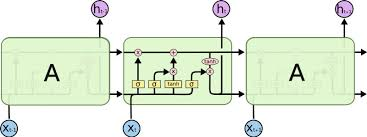


As we have seen in previous scenarios, results are quite good although there are still a possibility to improve them.

In this third scenario, we will implement an LSTM model. LSTM are temporal model invented to deal with temporal data, for this reason they are a good choice for our task. 

The main advantages of these models are: they can work directly with raw data without any pre-selection of features, and they also can implement internally more complex functions than other algorithms.

In general, as deeper the network is, more complex function approximates although there is a saturation point, in which the model could start to show over-fitting if it is too complex for the data provided.

As we know, each instance consists of a serie of samples obtained during 4 seconds at a sampling frequency of 50 Hz, which gives 200 samples per component (X, Y, Z axis of accelerometer), thus our time-steps are 200.

First of all, we should prepare the data for having the expected size that the LSTM needs to receive, we do this by calling to the function: PrepareData(...) that will return an array with the shape: (x,200,3).

After having the datasets ready in array formats, we build a simple LSTM model with a single layer of 200 neurons, train it and evaluate it on test set.

Let's see the performance of the model and its results. 

**Note**: To accelerate the LSTM training, it is highly recommended to use a Collab environment with GPU: Edit > Notebook settings or Runtime> Hardware accelerator select GPU.

If the environment is working with a GPU, after running next code cell it should print something like this:

TEST GPU is working: /device:GPU:0

If the result is just:


TEST GPU is working:

It means that you are not running on a GPU.



In [98]:

import tensorflow as tf
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
print("TEST GPU is working: ", tf.test.gpu_device_name())

TEST GPU is working:  /device:GPU:0


In [99]:
#PREPARE DATA FOR TRAINING/TESTING
df_train_csv, df_test_csv = DownloadDS()

X_train, y_train = PrepareData(df_train_csv, num_steps = 200, dimensions=3)
X_test, y_test = PrepareData(df_test_csv, num_steps = 200, dimensions=3)

#SPLIT TRAINING SET INTO TRAINING SET AND VALIDATION SET
#X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.3)

18-RJ9PKMCfHBOHHd_DRhAa2BjGjW1KuM
1lstZNOfbibRMXls5Qnkigjc8LREGVlog


In [100]:
df_test_csv

,param1,param2,param3,param4,param5,param6,param7,param8,param9,param10,param11,param12,param13,param14,param15,param16,param17,param18,param19,param20,param21,param22,param23,param24,param25,param26,param27,param28,param29,param30,param31,param32,param33,param34,param35,param36,param37,param38,param39,param40,...,param563,param564,param565,param566,param567,param568,param569,param570,param571,param572,param573,param574,param575,param576,param577,param578,param579,param580,param581,param582,param583,param584,param585,param586,param587,param588,param589,param590,param591,param592,param593,param594,param595,param596,param597,param598,param599,param600,class,user
0,62234635,46675980,35186508,48351525,56489903,31596047,-2393640,-100054148,-159177056,-367423741,-498595178,-560111746,-483754623,-461015064,-413142243,-310455108,-381785585,-430376473,-406679433,-313088110,-124708641,-43803612,3829824,61995272,191969922,386572846,605351536,605351536,-953865528,-931604652,-374604648,-240321455,-268566416,-19388483,70851743,94548775,72287928,47633436,52660079,67021919,...,72048565,38058876,24654492,87846587,185507097,-125426737,-569686327,39016332,-56968633,-255640736,-92633863,30159863,-26090675,5266008,74442203,116570267,115852170,77075205,49069618,-29441772,-5505372,15079932,50266437,72766655,-40691877,-181916644,-149363133,-253965187,-53378172,-34947141,-57447359,-21542760,75639026,120639454,152235505,163964332,153432327,112740443,1,0
1,-424152989,-317157304,-290109166,-213273317,-70612380,3590460,73963477,153671683,197714666,264018481,407397529,141224759,-921790743,-634553934,-403567691,-244869361,-321465854,-63431458,47633436,122315003,30877954,33510959,29920499,42606789,75399656,111543620,53378172,-120160728,-527318864,-1046499340,-580697044,-58404815,157022781,-74681567,-430615829,-557000033,-429897732,-313806206,-182156000,-182156000,...,-104123335,-112979806,-70851743,295853909,-303752913,-402131498,-176889997,-97660510,-48112162,22978944,-30399228,-28723679,10053288,39495058,82819941,112261717,136676839,118485179,82101851,29202407,64628281,194602924,-386812202,-462451228,-5505372,-301119912,-175693174,-35665234,-67021919,-66303829,48351525,49787711,100054148,150081230,161810057,141464115,129495917,120400091,1,0
2,-111304257,-148166310,-111304257,58165452,119203268,34947141,-25372584,-53856898,-61037820,35904601,51941986,9095832,-236730987,-481361007,-766443497,-806656670,239364,126384190,-17952301,-417211438,-503382469,-402370883,-342769249,-193645471,-94788146,37819513,87846587,152474860,208486041,269045127,251332186,16994845,-703969506,-500270756,-345162894,-32314140,-215427592,-139549210,118724542,124469270,...,-125666093,-256598218,-159655782,-216385045,-77314568,-65346370,-57686722,56011173,211837139,222608514,215188236,126384190,65825096,3829824,-17473571,46436613,244390635,-615165444,-398062333,73006018,-154629136,-320269017,9095832,-51941986,-60559090,68218741,112022346,141703485,148645037,104841432,41409970,24175763,-2154276,-12925656,23697036,-208007315,35186508,-55771810,1,0
3,-976365731,-299923074,95266872,327449953,-430376473,-714262184,-541920064,-348274607,-194602924,-55053721,22500216,39495058,42367426,48830255,54096261,111782983,167315430,208486041,-86171038,-773624404,-406440077,-206810492,-142900308,-245108731,3590460,178804902,128059738,61995272,28244951,2633004,-3111732,40213151,27287495,-90479588,-274311130,-576388523,-1071153891,-652266905,32074777,277901612,...,-93112597,-285561260,-123990544,-59840997,-111543620,-70612380,-2633004,113697895,146730132,221890417,224044692,126623560,63670821,2154276,-6223464,-56250540,-98857333,-538329639,-179283628,-35186508,-337263861,-223565966,-74442203,-77075205,-37101420,32553503,145533309,234097986,240082085,170427157,140985389,84016763,49308985,-5744736,-155825958,-11010744,-175453804,-189576292,1,0
4,-746336910,-428940280,-71569832,-115373444,-14361840,139788566,66543193,-30638591,-57686722,-1436184,6462828,-3351096,-51463260,-95506235,-264018481,-469871520,-8126

In [101]:
# tUT
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [102]:
import numpy as np
import tensorflow as tf
import datetime, os

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)


In [103]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 4718), started 0:51:09 ago. (Use '!kill 4718' to kill it.)

<IPython.core.display.Javascript object>

In [104]:

callback_EarlyStopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True
)

model_lstm_ES = CreateLSTM(neurons_first_layer = 200, n_steps = 200, dimension = 3, loss='categorical_crossentropy',
               optimizer='rmsprop', metrics=['accuracy'])
#Train model
model_lstm_ES.fit(X_train, 
               y_train, 
               batch_size=16, 
               epochs=5, 
               callbacks = [tensorboard_callback]) # validation_data=(X_validation, y_validation),

Epoch 1/5
  2/200 [..............................] - ETA: 3:59 - loss: 1.4842 - accuracy: 0.3750

200/200 [==============================] - 62s 312ms/step - loss: 1.1239 - accuracy: 0.4984
Epoch 2/5
200/200 [==============================] - 60s 299ms/step - loss: 0.8544 - accuracy: 0.6734
Epoch 3/5
200/200 [==============================] - 60s 299ms/step - loss: 0.7271 - accuracy: 0.7366
Epoch 4/5
200/200 [==============================] - 60s 299ms/step - loss: 0.6535 - accuracy: 0.7619
Epoch 5/5
200/200 [==============================] - 60s 301ms/step - loss: 0.6027 - accuracy: 0.7825


In [ ]:

callback_EarlyStopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True
)

model_lstm_ES = CreateLSTM(neurons_first_layer = 200, n_steps = 200, dimension = 3, loss='categorical_crossentropy',
               optimizer='rmsprop', metrics=['accuracy'])
#Train model
model_lstm_ES.fit(X_train, 
               y_train, 
               batch_size=16, 
               epochs=15, 
               callbacks = [tensorboard_callback]) # validation_data=(X_validation, y_validation),

Epoch 1/15
  2/200 [..............................] - ETA: 3:56 - loss: 1.8285 - accuracy: 0.2188

200/200 [==============================] - 63s 316ms/step - loss: 1.1188 - accuracy: 0.5031
Epoch 2/15
200/200 [==============================] - 60s 302ms/step - loss: 0.8405 - accuracy: 0.6859
Epoch 3/15
200/200 [==============================] - 60s 302ms/step - loss: 0.7145 - accuracy: 0.7506
Epoch 4/15
200/200 [==============================] - 60s 302ms/step - loss: 0.6420 - accuracy: 0.7806
Epoch 5/15
200/200 [==============================] - 60s 301ms/step - loss: 0.5924 - accuracy: 0.7991
Epoch 6/15
 62/200 [========>.....................] - ETA: 41s - loss: 0.5671 - accuracy: 0.7843

In [ ]:
#EVAL LSTM MODEL
#Predict classes on training/validation/test sets
y_pred_train_ES = model_lstm_ES.predict_classes(X_train)
#y_pred_val = model_lstm.predict_classes(X_validation)
y_pred_test_ES = model_lstm_ES.predict_classes(X_test)


#Eval model on training/validation/test sets
print("---- TRAINING RESULTS: -----")
EvalLSTM(y_train, y_pred_train_ES)
#print("---- VALIDATION RESULTS: -----")
#EvalLSTM(y_validation, y_pred_val)
print("---- TEST RESULTS: -----")
EvalLSTM(y_test, y_pred_test_ES)

In [ ]:
# Extract distribution of predictions: 
y_pred_example = model_lstm_ES.predict(X_test)
print(y_pred_example)

In [ ]:
Recognize_LSTM(model_lstm_ES,X_test,y_test)

In [ ]:
#SAVE LSTM
out_path_model_lstm_json = "models/trained_LSTM_raw.json"
out_path_model_lstm_h5 = "models/trained_LSTM_raw.h5"
# serialize model to JSON
!cd content; mkdir models
model_json = model_lstm_ES.to_json()
with open(out_path_model_lstm_json, "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_lstm_ES.save_weights(out_path_model_lstm_h5)
print("Saved model to disk")

In [ ]:
from keras.models import model_from_json
#LOAD MODELS:
# load json and create model
json_file = open(out_path_model_lstm_json, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(out_path_model_lstm_h5)
print("Loaded model from disk")

#Check loaded model
y_pred_example = loaded_model.predict(X_test)
print(y_pred_example)

## Systems Comparison

In this last section, we will compare results obtained from our trained models.

**TO DO:** Modify the accuracy values in the cell below with the accuracy reached by your models and comment the results. 

In [ ]:
num_samples_test = 3840 #len(y_test)

raw_system_test_acc = 53.05
CI_raw = CalculateCI(num_samples_test, raw_system_test_acc)
feature_system_test_acc = 50.13
CI_mfcc = CalculateCI(num_samples_test, feature_system_test_acc)
lstm_system_test_acc = 73.49
CI_lstm = CalculateCI(num_samples_test, lstm_system_test_acc)

print("Raw data max. acc: ", raw_system_test_acc+CI_raw)
print("MFCC max. acc: ",feature_system_test_acc+CI_mfcc)
print("LSTM max. acc: ",lstm_system_test_acc+CI_lstm)

In [ ]:
# PLOT RESULTS
import matplotlib.pyplot as plt
import numpy as np

#ARRAYS/INFO TO PLOT
means = [raw_system_test_acc, feature_system_test_acc, lstm_system_test_acc]
CI = [CI_raw, CI_mfcc, CI_lstm]

#PLOT DATA
fig,ax = plt.subplots(1)
plt.errorbar([0], [raw_system_test_acc], yerr=[CI_raw], fmt='o',label='RawData+J48', color="blue")
plt.errorbar([0.5], [feature_system_test_acc], yerr=[CI_mfcc], fmt='o', label='MFCCData+J48', color="red")
plt.errorbar([1], [lstm_system_test_acc], yerr=[CI_lstm], fmt='o',label='RawData+LSTM', color="green")
#FORMAT OF PLOT
plt.xlim(-0.25, 1.25)
plt.legend(loc='lower right')
plt.ylabel('Accuracy ± CI (%)')
plt.xlabel('Models')
ax.set_xticklabels([])


# Assignment 

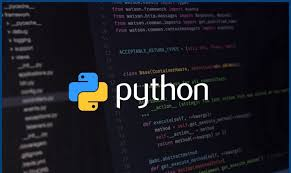



Time to work! :)

Re-run the notebook for a different task 
* Using a new dataset: INSE1920-challenge-ASSIGNMENT.csv
* Create new train and test partitions
* Try a different Weka classifier: Random Forest, NB, SVM, NN, ...
* Add a paragraph (text cell) at the end of this notebook briefly summarizing/discussing the obtained results 
(captions are allowed)
* Save the .ipynb notebook and submit it to [Fernando](fernando.fernandezm@upm.es) with the following subject:
  **INSE-SmartHealth-Team_XX-Pepito_y_Paquito**.

**OPTIONAL**
In case you may find the previous tasks to be a not so exciting ones you can definitely opt for the following alternative which means a **+5% extra score**:

* Design your own task by defining a new inventory of gestures:
  * Should be repetitive movements (to simplify the recording)
  * For example, “swimming” skills:
Backstrokes, Front crawl, Breaststroke, Butterfly, …
* Record your own dataset at home using the “Suite” app
  * Android and iOS versions available
  * Returns a .csv for every recording session
  * Additional libraries available (sampling rate and windowing) 
  * At least 1 minute per class, both members 
  * Same device, same hand
* Use the notebook to train and evaluate the system





# Conclusiones de la práctica
Para la partición de nuestro dataset entre ejemplos de entrenamiento y de test, hemos decidido realizar **Cross-Validation** con un número fijo de *folds* de 3, utilizando el calificador **Naive Bayes**. 

La separación de estos tres *folds* se ha seleccionado teniendo en cuenta que los ejemplos están divididos por 12 usuarios. Entonces, se ha decidido tener siempre todos los ejemplos de un mismo usuario dentro únicamente de una partición, ya sea test o entrenamiento. Ya que si tuviéramos ejemplos de un mismo usuario en entrenamiento y en test, los resultados podrían verse comprometidos. De esta forma, la separación quedaría así:

**Prueba 1**
- 3200 ejemplos de los usuarios 0-7 para entrenamiento
- 1600 ejemplos de los usuarios 8-11 para test

**Prueba 2**
- 3200 ejemplos de los usuarios 0-3 y 8-11 para entrenamiento
- 1600 ejemplos de los usuarios 4-7 para test

**Prueba 3**
- 3200 ejemplos de los usuarios 4-11 para entrenamiento
- 1600 ejemplos de los usuarios 0-3 para test

Con esto, hemos obtenido 3 resultados distintos correspondientes a cada una de las pruebas con los que calcularemos el porcentaje de acierto final para test y entrenamiento mediante la media de dichos resultados. 

***Tasa de acierto:***

|  | Entrenamiento | Test |
| :--: | :--: | :--: |
| **Prueba 1** | 91.9688 % | 77.9375 %|
| **Prueba 2** | 89.0313 % | 89.5 % |
| **Prueba 3** | 91.75 % | 87 % |
| **Media** | 90.9167 % | 84.8125 % |

Gracias a esto, podemos comprobar nuestro sistema entrenando con todos los ejemplos y realizando el test de todos ellos sin solapamiento de casos entre ambas particiones. 

# Appendix

# Physics Toolbox Suite

Normally, this subject englobes developing these models in an embedded environment, more specifically, in a Raspberry Pi. However, due to the sanitary conditions, this year it is impossible to provide this device to all the groups. For this reason, and to let you practice new algorithms and collect your own data for creating a new dataset, we encourage you to use your mobile phone with some of the available application for recording data from sensors. 

One of the most interesting could be:

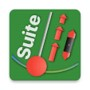


**Physics Toolbox Suite** (available on Play Store: https://play.google.com/store/apps/details?id=com.chrystianvieyra.physicstoolboxsuite&hl=es_419 ).
This application let capture data from gyroscopes, accelerometers, clinometers, ... The main advantage and attractiveness for this subject is that it allows uploading data to the cloud directly or save it in your mobile for posterior processing. 




# Evaluate new samples

In this section we will use Physics Toolbox Suite mobile application to record new samples and predict the class using our trained LSTM model

In [ ]:
def subsampling (reference_data, next_sample = 4):
  """
    Subsample data collected from Physics Toolbox Suite. As data probably is obtained at 200 Hz, the default configuration is 
    taking 1 sample of each 4, (that is wht next_sample = 4)
    :param reference_data: Dataframe with the raw samples obtained from application
    :param next_sample: Sample to take from each group of next_sample (1 of next_sample)
    :return subsampled dataframe
  """
  new_df = pd.DataFrame([], columns=reference_data.columns)
  for i, row in reference_data.iterrows():
    if((i%next_sample)==0): #Maintain sample if sample is multiple of next_sample
      new_df = new_df.append(pd.DataFrame([row], columns=reference_data.columns))
  new_df.reset_index(drop=True, inplace=True)
  return new_df

def cut_samples(df2cut, max_parameters = 200, cut_first_N_samples = True, cut_last_M_samples = True):
  """
    Reduce number of timesteps to the number indicated in max_parameters. If cut_first_N_samples is True and/or cut_last_M_samples is True it means that
    we will remove samples from the beginning and/or end of the dataframe.  
    :param df2cut: Dataframe with the samples to reduce.
    :param max_parameters: Maximum number of timesteps (or samples) to maintain
    :param cut_first_N_samples: True if we want to remove samples from the beginning of the dataframe
    :param cut_first_N_samples: True if we want to remove samples from the end of the dataframe
    :return Reduced dataframe with as many samples as those indicated by max_parameters
  """
  N = len(df2cut)-max_parameters
  M = len(df2cut)-max_parameters
  if(cut_first_N_samples and cut_last_M_samples):
    N = int((len(df2cut)-200)/2)
    if(M%2 ==0):
      M = N
    else:
      M = N+1
  if(cut_first_N_samples):
    #Remove N samples from the beginning of the dataframe
    df2cut = df2cut.iloc[N:]
  if(cut_last_M_samples):
    #Remove M samples from the end of the dataframe
    df2cut = df2cut.iloc[:-M]
  df2cut.reset_index(drop=True, inplace=True)
  return df2cut

def refactor_DS(df2refactor, user = 80, class_name="UNK"):
  """
    Modify the structure of the dataframe in order to be processed by PrepareData.
    :param df2refactor: Dataframe with the samples to refactor.
    :param user: Number of the user to append.
    :param class_name: Class name of the sample, if it is not known just maintain UNK
    :return Dataframe with X,Y,Z accelerometer data, user and class (as the format expected by PrepareData)
  """
  refactored_df = pd.DataFrame([np.concatenate((df2refactor["ax"], df2refactor["ay"],df2refactor["az"]), axis=None)], columns =  ["param"+str(i) for i in range(0,len(df2refactor)*3)])
  refactored_df["user"] = user
  refactored_df["class"] = class_name
  return refactored_df
  

def predict_new_sample(df_loaded_sample,LSTM_model, expected_label = "LOB"):
  """
    Functions prepared for predicting class of new sample from data extracted by Physics Toolbox Suite application.
  """
  if(expected_label=="DRIVE"):
    y_sample = [[1.0,0.0,0.0,0.0]]
  elif(expected_label=="BACKHAND"):
    y_sample = [[0.0,1.0,0.0,0.0]]
  elif(expected_label=="SERVE"):
    y_sample = [[0.0,0.0,1.0,0.0]]
  elif(expected_label=="LOB"):
    y_sample = [[0.0,0.0,0.0,1.0]]
  else:
    y_sample = [[1.0,0.0,0.0,0.0]]

  #RENAME COLUMNS
  df_loaded_sample.columns = ["time", "ax", "ay", "az","aT"]
  #CHANGE COMMAS BY POINTS
  df_loaded_sample = df_loaded_sample.apply(lambda x: x.str.replace(',','.'))
  #CONVERT COLUMNS TO FLOAT
  for col in df_loaded_sample.columns:
    df_loaded_sample[col] = df_loaded_sample[col].astype(float)

  #SUBSAMPLE (SAMPLING FREQ OF APP AROUND 200 HZ (4x OF REFERENCE FREQ. 50 HZ))
  new_df_subsampled = subsampling (df_loaded_sample, next_sample = 4)

  #REDUCE SAMPLES TO 200 (4 SECONDS)
  cutted_df = cut_samples(new_df_subsampled, max_parameters = 200, cut_first_N_samples = True, cut_last_M_samples = True)

  # REFACTOR DF TO USE PREPAREDS FUNCTION
  refactored_df = refactor_DS(cutted_df, user = 80, class_name="UNK")

  #PREPARE SAMPLE
  X_sample, _ = PrepareData(refactored_df, num_steps = 200, dimensions=3)

  #EXTRACT PREDICTION
  Recognize_LSTM(LSTM_model,X_sample.reshape(1,200,3),y_sample)


In [ ]:
#EVAL NEW SAMPLES TAKING USING PHYSICS TOOLBOX SUITE WITH YOUR MODEL
#PRE-RECORD SAMPLES AND UPLOAD THEM TO samples_app FOLDER (YOU NEED TO CREATE IT PREVIOUSLY)
df_sample_drive = pd.read_csv("../content/samples_app/drive.csv", sep=";", header=0)
predict_new_sample(df_sample_drive,loaded_model, expected_label = "DRIVE")

df_sample_bkhand = pd.read_csv("../content/samples_app/backhand.csv", sep=";", header=0)
predict_new_sample(df_sample_bkhand,loaded_model, expected_label = "BACKHAND")

df_sample_serve = pd.read_csv("../content/samples_app/serve.csv", sep=";", header=0)
predict_new_sample(df_sample_serve,loaded_model, expected_label = "SERVE")

df_sample_lob = pd.read_csv("../content/samples_app/lob.csv", sep=";", header=0)
predict_new_sample(df_sample_lob,loaded_model, expected_label = "LOB")


## Upload files (or datasets)

In [ ]:
from google.colab import files

uploaded = files.upload()

In [ ]:
#FOR DOCUMENTS
import pandas as pd
data_file = 'example.csv'
data = pd.read_csv(data_file)
print(data)



In [ ]:
#IF ERRORS IN GOOGLE DRIVE, UPLOAD DATASETS MANUALLY
from google.colab import files
import pandas as pd
upl_train =files.upload()
upl_test=files.upload()


col_names = ["param"+str(i) for i in range(1,601)]
col_names = col_names+["class", "user"]

df_train_csv = pd.read_csv('INSE1819-challenge-TRAIN_pingPong.csv', sep=" ", header=None)
df_test_csv = pd.read_csv('INSE1819-challenge-TEST_pingPong.csv', sep=" ", header=None)

df_train_csv.columns = col_names
df_test_csv.columns = col_names

## Download files (datasets, models...)

In [ ]:
from google.colab import files
files.download(out_path_model)


## Save files in your Collab session

To save data in your Collab session you can use the same commands that you would run in your own computer (in local). Below we can see some examples.

**IMPORTANT**: Any data that you save here will be removed after a certain time, so it is better to download important files if you want to maintain them (check previous section: Download files).

In [ ]:
#Commands here are the same that you would use in your own machine (in local). 
#Below
#FOR DATAFRAMES:
import pandas as pd
data_file = 'example.csv'
data.to_csv(data_file)

#FOR MODELS: 
import weka.core.jvm as jvm
import weka.core.serialization as serialization
jvm.start(max_heap_size="1200m")
output_path_model = "models/test.model"
serialization.write(output_path_model, trained_model)


## Save and Load networks




In [ ]:
#SAVE MODELS
out_path_model_lstm_json = "models/trained_LSTM_raw.json"
out_path_model_lstm_h5 = "models/trained_LSTM_raw.h5"
# serialize model to JSON
model_json = model_lstm_ES.to_json()
with open(out_path_model_lstm_json, "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_lstm_ES.save_weights(out_path_model_lstm_h5)
print("Saved model to disk")

In [ ]:
from keras.models import model_from_json
#LOAD MODELS:
# load json and create model
json_file = open(out_path_model_lstm_json, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(out_path_model_lstm_h5)
print("Loaded model from disk")

# Dataset as ARFF

In [ ]:
#Download datasets (and save them for loading them later) - ARFF
link_train_arff = "https://drive.google.com/file/d/1u42itK3PsIzggUN56J8hsTmLRx7uoujj/view?usp=sharing"
id_train_arff = link_train_arff.split('/d/')[1].split("/")[0]
#print (id_train_arff) # Verify that id is ok

downloaded = drive.CreateFile({'id':id_train_arff}) 
downloaded.GetContentFile('df_train.arff')  

link_test_arff = "https://drive.google.com/file/d/1tw0CJloEnOOzeEAskw0cp6yXZhaSE6oC/view?usp=sharing"
id_test_arff = link_test_arff.split('/d/')[1].split("/")[0]
#print (id_test_arff) # Verify that id is ok

downloaded = drive.CreateFile({'id':id_test_arff}) 
downloaded.GetContentFile('df_test.arff')  

In [ ]:
import weka.core.jvm as jvm
#Create new instance of java virtual machine for running weka
jvm.start(max_heap_size="1200m")
#Load datasets
dataset_train_weka = LoadDataset('df_train.arff', debug = False)
dataset_test_weka = LoadDataset('df_test.arff', debug = False)

print('Sample size training: ', dataset_train_weka.num_instances)
print('Sample size testing: ', dataset_test_weka.num_instances)  


In [ ]:
#https://stackoverflow.com/questions/52859983/interactive-matplotlib-figures-in-google-colab